In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.tsa.tsatools import detrend
from CMI_knn import CMI_KNN
from pcmciminus import pcmcim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
from itertools import combinations
from scipy.integrate import odeint
from scipy.stats import linregress, t
from scipy import stats
from statsmodels.tsa import stattools
from sklearn.feature_selection import mutual_info_regression

import numpy as np
from scipy import stats, linalg

def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    P_value = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            pval = stats.pearsonr(res_i, res_j)[1]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
            P_value[i, j] = pval
            P_value[j, i] = pval
        
    return P_corr[0,1], P_value[0,1]

In [3]:
df_mix_msa = pd.read_csv("/Users/tg2426/Documents/Python/Covid/df_mix_msa.csv")
df_mix_msa

,Unnamed: 0.2,index,Unnamed: 0.1,cbsa10,Unnamed: 0,FIPS,Total Population_x,4/3/21_covid,4/3/21_death,4/3/21_complete,...,Total Population_y,Smoking,Uninsured,60plus,all_icu,Hospitals_in_HC,DEMOCRAT,REPUBLICAN,60minus,Total Population
0,0,0,0,C1010,3149,92058.0,43191,5824,104,9115.0,...,43191,6121.063020,3764.0,9764,10,3,6955,12118,33427,43191
1,1,1,2,C1022,1450,40123.0,38247,5037,50,9403.0,...,38247,7378.840724,5411.0,8264,12,2,4117,10805,29983,38247
2,2,2,4,C1042,781,78286.0,704845,55572,1137,91030.0,...,704845,130674.217957,38313.0,161110,186,5,187329,170823,543735,704845
3,3,3,5,C1046,2082,35035.0,66781,3649,72,10942.0,...,66781,12584.005394,5642.0,14360,10,2,8485,14521,52421,66781
4,4,4,6,C1048,6284,24047.0,28711,2053,42,833.0,...,28711,4712.924606,2798.0,6258,6,2,7029,6840,22453,28711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,756,756,833,C4946,331,46135.0,22869,2946,28,5463.0,...,22869,3346.111978,1562.0,5565,10,1,4016,6581,17304,22869
690,757,757,834,C4962,1417,42133.0,448273,40395,752,68799.0,...,448273,71776.940967,23695.0,99386,60,5,88114,146733,348887,448273
691,758,758,835,C4966,4593,78254.0,428269,35508,1067,67276.0,...,428269,86125.242553,24038.0,117766,109,5,102160,115097,310503,428269
692,759,759,836,C4970,3578,12216.0,174848,15064,149,25285.0,...,174848,22008.103173,11864.0,31546,24,2,28597,42051,143302,174848


In [7]:
dataset = df_mix_msa
t = 1
for t in range(1,429,7):
    treal =t+7
    print(t, dataset.columns[4*treal-5+7*4],dataset.columns[ 4*treal-5])
    col = dataset.columns[4*treal-5+7*4]+'_weekly_incre'
    daily_increase = dataset.iloc[:, 4*treal-5+7*4] - dataset.iloc[:, 4*treal-5]

    dataset[col] = daily_increase

    # t+=7

T = 37
for t in range(T):
    print(dataset.columns[4*433+4*t+8-1+7*4], dataset.columns[4*433+4*t+4-1+7*4],)
    col = dataset.columns[4*433+4*t+8-1+7*4]+'_weekly_incre'
    daily_increase = dataset.iloc[:, 4*433+4*t+8-1+7*4] - dataset.iloc[:, 4*433+4*t+4-1+7*4]
    dataset[col] = daily_increase

t = 1
for t in range(1,429,7):
    treal =t+7
    print(t, dataset.columns[4*treal-4+7*4],dataset.columns[ 4*treal-4])
    col = dataset.columns[4*treal-4+7*4]+'_weekly_incre'
    daily_increase = dataset.iloc[:, 4*treal-4+7*4] - dataset.iloc[:, 4*treal-4]

    dataset[col] = daily_increase

    # t+=7

T = 37
for t in range(T):
    print(dataset.columns[4*433+4*t+9-1+7*4], dataset.columns[4*433+4*t+5-1+7*4],)
    col = dataset.columns[4*433+4*t+9-1+7*4]+'_weekly_incre'
    daily_increase = dataset.iloc[:, 4*433+4*t+9-1+7*4] - dataset.iloc[:, 4*433+4*t+5-1+7*4]

    dataset[col] = daily_increase

    # t+=7


for t in range(1,429,7):
    treal =t+7
    print(t, dataset.columns[4*treal-3+7*4],dataset.columns[ 4*treal-3])
    col = dataset.columns[4*treal-3+7*4]+'_weekly_incre'
    daily_increase = dataset.iloc[:, 4*treal-3+7*4] - dataset.iloc[:, 4*treal-3]

    dataset[col] = daily_increase

    # t+=7

T = 37
for t in range(T):
    print(dataset.columns[4*433+4*t+10-1+7*4], dataset.columns[4*433+4*t+6-1+7*4],)
    col = dataset.columns[4*433+4*t+10-1+7*4]+'_weekly_incre'
    daily_increase = dataset.iloc[:, 4*433+4*t+10-1+7*4] - dataset.iloc[:, 4*433+4*t+6-1+7*4]

    dataset[col] = daily_increase

    # t+=7

dataset

1 4/15/21_covid 4/8/21_covid
8 4/22/21_covid 4/15/21_covid
15 4/29/21_covid 4/22/21_covid
22 5/6/21_covid 4/29/21_covid
29 5/13/21_covid 5/6/21_covid
36 5/20/21_covid 5/13/21_covid
43 5/27/21_covid 5/20/21_covid
50 6/3/21_covid 5/27/21_covid
57 6/10/21_covid 6/3/21_covid
64 6/17/21_covid 6/10/21_covid
71 6/24/21_covid 6/17/21_covid
78 7/1/21_covid 6/24/21_covid
85 7/8/21_covid 7/1/21_covid
92 7/15/21_covid 7/8/21_covid
99 7/22/21_covid 7/15/21_covid
106 7/29/21_covid 7/22/21_covid
113 8/5/21_covid 7/29/21_covid
120 8/12/21_covid 8/5/21_covid
127 8/19/21_covid 8/12/21_covid
134 8/26/21_covid 8/19/21_covid
141 9/2/21_covid 8/26/21_covid
148 9/9/21_covid 9/2/21_covid
155 9/16/21_covid 9/9/21_covid
162 9/23/21_covid 9/16/21_covid
169 9/30/21_covid 9/23/21_covid
176 10/7/21_covid 9/30/21_covid
183 10/14/21_covid 10/7/21_covid
190 10/21/21_covid 10/14/21_covid
197 10/28/21_covid 10/21/21_covid
204 11/4/21_covid 10/28/21_covid
211 11/11/21_covid 11/4/21_covid
218 11/18/21_covid 11/11/21_covid

,Unnamed: 0.2,index,Unnamed: 0.1,cbsa10,Unnamed: 0,FIPS,Total Population_x,4/3/21_covid,4/3/21_death,4/3/21_complete,...,12/28/22_complete_weekly_incre,1/4/23_complete_weekly_incre,1/11/23_complete_weekly_incre,1/18/23_complete_weekly_incre,1/25/23_complete_weekly_incre,2/1/23_complete_weekly_incre,2/8/23_complete_weekly_incre,2/15/23_complete_weekly_incre,2/22/23_complete_weekly_incre,3/1/23_complete_weekly_incre
0,0,0,0,C1010,3149,92058.0,43191,5824,104,9115.0,...,22.0,10.0,1.0,19.0,17.0,8.0,11.0,12.0,0.0,10.0
1,1,1,2,C1022,1450,40123.0,38247,5037,50,9403.0,...,-1.0,22.0,7.0,12.0,4.0,8.0,4.0,2.0,7.0,8.0
2,2,2,4,C1042,781,78286.0,704845,55572,1137,91030.0,...,163.0,165.0,202.0,184.0,191.0,195.0,201.0,184.0,198.0,173.0
3,3,3,5,C1046,2082,35035.0,66781,3649,72,10942.0,...,37.0,27.0,38.0,25.0,30.0,23.0,33.0,26.0,11.0,35.0
4,4,4,6,C1048,6284,24047.0,28711,2053,42,833.0,...,0.0,1.0,6.0,10.0,4.0,4.0,6.0,7.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,756,756,833,C4946,331,46135.0,22869,2946,28,5463.0,...,11.0,7.0,8.0,13.0,14.0,11.0,10.0,4.0,4.0,12.0
690,757,757,834,C4962,1417,42133.0,448273,40395,752,68799.0,...,161.0,216.0,183.0,188.0,124.0,192.0,141.0,122.0,103.0,107.0
691,758,758,835,C4966,4593,78254.0,428269,35508,1067,67276.0,...,101.0,58.0,99.0,77.0,83.0,76.0,75.0,69.0,79.0,47.0
692,759,759,836,C4970,3578,12216.0,174848,15064,149,25285.0,...,75.0,26.0,46.0,40.0,33.0,39.0,40.0,28.0,20.0,25.0


In [45]:
print(dataset.columns[4*433+4-1+7*4] ,dataset.columns[4*428+3+7*4])

6/16/22_covid 6/11/22_covid


In [8]:
t = 1
for t in range(1,429,7):
    treal =t+7
    print(t, dataset.columns[4*treal-5+7*4],dataset.columns[ 4*treal-5])
    col = dataset.columns[4*treal-5+7*4]+'_weekly'
    daily_increase = dataset.iloc[:, 4*treal-5+7*4]
    dataset[col] = daily_increase
    # t+=7

T = 37
for t in range(T):
    print(dataset.columns[4*433+4*t+8-1+7*4], dataset.columns[4*433+4*t+4-1+7*4],)
    col = dataset.columns[4*433+4*t+8-1+7*4]+'_weekly'
    daily_increase = dataset.iloc[:, 4*433+4*t+8-1+7*4]
    dataset[col] = daily_increase


for t in range(1,429,7):
    treal =t+7
    print(t, dataset.columns[4*treal-4+7*4],dataset.columns[ 4*treal-4])
    col = dataset.columns[4*treal-4+7*4]+'_weekly'
    daily_increase = dataset.iloc[:, 4*treal-4+7*4]
    dataset[col] = daily_increase
    # t+=7

T = 37
for t in range(T):
    print(dataset.columns[4*433+4*t+9-1+7*4], dataset.columns[4*433+4*t+5-1+7*4],)
    col = dataset.columns[4*433+4*t+9-1+7*4]+'_weekly'
    daily_increase = dataset.iloc[:, 4*433+4*t+9-1+7*4]
    dataset[col] = daily_increase
    # t+=7

for t in range(1,429,7):
    treal =t+7
    print(t, dataset.columns[4*treal-3+7*4],dataset.columns[ 4*treal-3])
    col = dataset.columns[4*treal-3+7*4]+'_weekly'
    daily_increase = dataset.iloc[:, 4*treal-3+7*4]
    dataset[col] = daily_increase
    # t+=7

T = 37
for t in range(T):
    print(dataset.columns[4*433+4*t+10-1+7*4], dataset.columns[4*433+4*t+6-1+7*4],)
    col = dataset.columns[4*433+4*t+10-1+7*4]+'_weekly'
    daily_increase = dataset.iloc[:, 4*433+4*t+10-1+7*4]
    dataset[col] = daily_increase
    # t+=7

dataset

1 4/15/21_covid 4/8/21_covid
8 4/22/21_covid 4/15/21_covid
15 4/29/21_covid 4/22/21_covid
22 5/6/21_covid 4/29/21_covid
29 5/13/21_covid 5/6/21_covid
36 5/20/21_covid 5/13/21_covid
43 5/27/21_covid 5/20/21_covid
50 6/3/21_covid 5/27/21_covid
57 6/10/21_covid 6/3/21_covid
64 6/17/21_covid 6/10/21_covid
71 6/24/21_covid 6/17/21_covid
78 7/1/21_covid 6/24/21_covid
85 7/8/21_covid 7/1/21_covid
92 7/15/21_covid 7/8/21_covid
99 7/22/21_covid 7/15/21_covid
106 7/29/21_covid 7/22/21_covid
113 8/5/21_covid 7/29/21_covid
120 8/12/21_covid 8/5/21_covid
127 8/19/21_covid 8/12/21_covid
134 8/26/21_covid 8/19/21_covid
141 9/2/21_covid 8/26/21_covid
148 9/9/21_covid 9/2/21_covid
155 9/16/21_covid 9/9/21_covid
162 9/23/21_covid 9/16/21_covid
169 9/30/21_covid 9/23/21_covid
176 10/7/21_covid 9/30/21_covid
183 10/14/21_covid 10/7/21_covid
190 10/21/21_covid 10/14/21_covid
197 10/28/21_covid 10/21/21_covid
204 11/4/21_covid 10/28/21_covid
211 11/11/21_covid 11/4/21_covid
218 11/18/21_covid 11/11/21_covid

/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_80788/3923163098.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[col] = daily_increase
/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_80788/3923163098.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[col] = daily_increase
/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_80788/3923163098.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

,Unnamed: 0.2,index,Unnamed: 0.1,cbsa10,Unnamed: 0,FIPS,Total Population_x,4/3/21_covid,4/3/21_death,4/3/21_complete,...,12/28/22_complete_weekly,1/4/23_complete_weekly,1/11/23_complete_weekly,1/18/23_complete_weekly,1/25/23_complete_weekly,2/1/23_complete_weekly,2/8/23_complete_weekly,2/15/23_complete_weekly,2/22/23_complete_weekly,3/1/23_complete_weekly
0,0,0,0,C1010,3149,92058.0,43191,5824,104,9115.0,...,25295.0,25305.0,25306.0,25325.0,25342.0,25350.0,25361.0,25373.0,25373.0,25383.0
1,1,1,2,C1022,1450,40123.0,38247,5037,50,9403.0,...,20355.0,20377.0,20384.0,20396.0,20400.0,20408.0,20412.0,20414.0,20421.0,20429.0
2,2,2,4,C1042,781,78286.0,704845,55572,1137,91030.0,...,451234.0,451399.0,451601.0,451785.0,451976.0,452171.0,452372.0,452556.0,452754.0,452927.0
3,3,3,5,C1046,2082,35035.0,66781,3649,72,10942.0,...,43211.0,43238.0,43276.0,43301.0,43331.0,43354.0,43387.0,43413.0,43424.0,43459.0
4,4,4,6,C1048,6284,24047.0,28711,2053,42,833.0,...,16062.0,16063.0,16069.0,16079.0,16083.0,16087.0,16093.0,16100.0,16106.0,16111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,756,756,833,C4946,331,46135.0,22869,2946,28,5463.0,...,15714.0,15721.0,15729.0,15742.0,15756.0,15767.0,15777.0,15781.0,15785.0,15797.0
690,757,757,834,C4962,1417,42133.0,448273,40395,752,68799.0,...,278740.0,278956.0,279139.0,279327.0,279451.0,279643.0,279784.0,279906.0,280009.0,280116.0
691,758,758,835,C4966,4593,78254.0,428269,35508,1067,67276.0,...,246702.0,246760.0,246859.0,246936.0,247019.0,247095.0,247170.0,247239.0,247318.0,247365.0
692,759,759,836,C4970,3578,12216.0,174848,15064,149,25285.0,...,105732.0,105758.0,105804.0,105844.0,105877.0,105916.0,105956.0,105984.0,106004.0,106029.0


In [9]:
dataset.to_csv('df_mix_msa_weekly.csv')

In [5]:
df_mix_county = pd.read_csv("/Users/tg2426/Documents/Python/Covid/df_mix_county.csv")
df_mix_county

,Unnamed: 0.1,Unnamed: 0,FIPS,Total Population,7/12/21,7/13/21_x,7/13/21_y,7/13/21,7/14/21_x,7/14/21_y,...,3/8/23,cbsa10,csatitle,Smoking,Uninsured,60plus,all_icu,Hospitals_in_HC,DEMOCRAT,REPUBLICAN
0,0,0,45083,313888,97106.0,42142,833,97224.0,42157,833,...,145402.0,C4390,"Greenville-Spartanburg-Anderson, SC",50672.485220,32367.0,63159,39,1,52926,93560
1,1,1,47105,53054,26225.0,6257,71,26225.0,6260,71,...,35505.0,C2894,"Knoxville-Morristown-Sevierville, TN",9480.827798,4920.0,16724,5,1,6948,21713
2,3,3,1101,225763,72779.0,25266,621,72868.0,25325,622,...,124329.0,C3386,"Montgomery-Selma, AL",44704.376889,20236.0,44214,88,3,64529,33311
3,4,4,19045,46518,19985.0,5625,93,20010.0,5629,93,...,26319.0,C1754,"Davenport-Moline, IA-IL",8149.474181,1831.0,12082,10,2,10812,13410
4,6,6,13305,29808,6632.0,3653,91,6632.0,3655,91,...,12973.0,C2770,"Savannah-Hinesville-Statesboro, GA",5532.996883,3397.0,6149,12,1,2687,9987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,1660,2845,18165,15479,5577.0,1787,44,5579.0,1789,44,...,7615.0,C4546,NaN,2961.912074,1004.0,4085,6,1,2145,5184
1138,1661,2849,39037,51323,11814.0,5432,131,11842.0,5432,131,...,21008.0,C2482,"Dayton-Springfield-Kettering, OH",9565.288928,3052.0,13217,6,1,4731,22004
1139,1663,2852,45057,95380,29317.0,11018,173,29346.0,11019,173,...,49385.0,C1674,"Charlotte-Concord, NC-SC",13640.166993,9515.0,22468,20,1,18937,30312
1140,1664,2855,36035,53591,22846.0,4437,93,22866.0,4438,93,...,29876.0,C2410,"Albany-Schenectady, NY",9918.787744,2437.0,13782,8,1,7931,15378


In [20]:
df_mix_msa.columns
#     df_mix_msa.drop(df_mix_msa[df_mix_msa[i] < 1].index,inplace=True)
# df_mix_msa

Index(['Unnamed: 0.2', 'index', 'Unnamed: 0.1', 'cbsa10', 'Unnamed: 0', 'FIPS',
       'Total Population_x', '4/3/21_covid', '4/3/21_death', '4/3/21_complete',
       ...
       '4/9/22_complete_weekly', '4/16/22_complete_weekly',
       '4/23/22_complete_weekly', '4/30/22_complete_weekly',
       '5/7/22_complete_weekly', '5/14/22_complete_weekly',
       '5/21/22_complete_weekly', '5/28/22_complete_weekly',
       '6/4/22_complete_weekly', '6/11/22_complete_weekly'],
      dtype='object', length=2049)

In [10]:
def SCAMIs(x0,y0):
    y = np.log(y0)
    X = np.log(x0)
    # res = linregress(X,y)
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    # print(intercept,slope)
    y_pred = model.params[0] + model.params[1]*X[:,0]+model.params[2]*X[:,1]+model.params[3]*X[:,2]
    SCAMIs = y-y_pred
    # print(reg.coef_)
    # print('coef',model.params.tolist())
    # print('pval',model.pvalues.tolist())
    # print('r2',model.rsquared)
    return SCAMIs

def SAMIs_normalize(x0,y0):
    """ 

    Parameters
    ----------
    x0: static variables of interest 
    
    Returns
    -------
    SAMIs: the residual of the multiple linear regression 
    coef: coefficients of the variables of interest from regression line
    """
    x = np.log(x0)
    y = np.log(y0)
    # x[:,0] = np.log(x[:,0])
    # fig,(ax) = plt.subplots(1,1,figsize=(10,10))
    V = x.shape[1]
    # res = linregress(X,y)
    # y = normalize(y)
    # for i in range(V):
    #     x[:,i] = normalize(x[:,i])
    X = sm.add_constant(x)
    # print(X.shape,y.shape)
    model = sm.OLS(y, X).fit()
    print('coef',model.params[1:].tolist())
    # print('pval',model.pvalues[1:].tolist())
    # print('r2',model.rsquared)
    coef = model.params[1:].tolist()
    # fig = plt.figure(figsize =(15,8))
    # fig =sm.graphics.plot_regress_exog(model,2, fig=fig)
    # fig.show()
    # print(intercept,slope)
    y_pred = model.params[0]  + np.sum([model.params[v+1]*np.log(x0)[:,v] for v in range(V)], axis=0)
    SAMIs = y-y_pred
    # ax.plot(y_pred,x[:,0],'o')
    # print(y_pred)
    # print(reg.coef_)
    
    # print(model.summary())
    # plt.hist(SAMIs)
    return SAMIs, coef

def normalize(x):
    x = np.array(x)
    return (x-np.mean(x))/np.var(x)

def FAMIs_normalize(x0,y0):
    """ 

    Parameters
    ----------
    x0: static variables of interest 
    
    Returns
    -------
    SCAMIs: the residual of the multiple linear regression 
    coef: coefficients of the variables of interest from regression line
    """
    x = np.log(x0)
    y = np.log(y0)
    # x[:,0] = np.log(x[:,0])
    # fig,(ax) = plt.subplots(1,1,figsize=(10,10))
    V = x.shape[1]
    # res = linregress(X,y)
    # y = normalize(y)
    # for i in range(V):
    #     x[:,i] = normalize(x[:,i])
    X = sm.add_constant(x)
    # print(X.shape,y.shape)
    model = sm.OLS(y, X).fit()
    print('coef',model.params[1:].tolist())
    # print('pval',model.pvalues[1:].tolist())
    # print('r2',model.rsquared)
    coef = model.params[1:].tolist()
    # fig = plt.figure(figsize =(15,8))
    # fig =sm.graphics.plot_regress_exog(model,2, fig=fig)
    # fig.show()
    # print(intercept,slope)
    y_pred = model.params[0]  + np.sum([model.params[v+1]*np.log(x0)[:,v] for v in range(V)], axis=0)
    SCAMIs = y-y_pred
    # ax.plot(y_pred,x[:,0],'o')
    # print(y_pred)
    # print(reg.coef_)
    
    # print(model.summary())
    # plt.hist(SCAMIs)
    return SCAMIs, coef

In [7]:
############# AFTER VACCINATION #############################

index = ['Total Population']
print(index)
dataset = df_mix_msa
static_variables=np.ones((len(dataset),len(index)),dtype=float)
for i in range(len(index)):
    static_variables[:,i] = dataset[index[i]]
# static_variables[:,1] = df_mix_msa['60plus']
# static_variables[:,2] = df_mix_msa['all_icu']
# static_variables[:,3] = df_mix_msa['Smoking']
# static_variables[:,4] = df_mix_msa['Uninsured']
# static_variables[:,5] = df_mix_msa['DEMOCRAT']
# static_variables[:,6] = df_mix_msa['REPUBLICAN']


T = int(len(dataset.columns[7:-10])/4)
# # T = 130-2
SAMIs_covid = np.ones((len(dataset),T))
SAMIs_death = np.ones((len(dataset),T))
SAMIs_vaccine_complete = np.ones((len(dataset),T))
SAMIs_vaccine_dose1 = np.ones((len(dataset),T))
SAMIs_covid_static = np.ones((static_variables.shape[1],T))
SAMIs_death_static = np.ones((static_variables.shape[1],T))
SAMIs_vaccine_complete_static = np.ones((static_variables.shape[1],T))
SAMIs_vaccine_dose1_static = np.ones((static_variables.shape[1],T))
MI_SAMIs_covid = np.ones((static_variables.shape[1],T))
MI_SAMIs_death = np.ones((static_variables.shape[1],T))
MI_SAMIs_vaccine_complete = np.ones((static_variables.shape[1],T))
MI_SAMIs_vaccine_dose1 = np.ones((static_variables.shape[1],T))
# Corr_SCAMIs_covid = np.ones((static_variables.shape[1],T))
# Corr_SCAMIs_death = np.ones((static_variables.shape[1],T))
# Corr_SCAMIs_vaccine_complete = np.ones((static_variables.shape[1],T))
# Corr_SCAMIs_vaccine_dose1 = np.ones((static_variables.shape[1],T))
for t in range(T):
    print(dataset.columns[4*t+7])
    SAMIs_covid[:,t], SAMIs_covid_static[:,t] = SAMIs_normalize(static_variables,dataset.iloc[:,4*t+7])
    MI_SAMIs_covid[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    # Corr_SCAMIs_covid[:,t] = np.array([pearsonr(static_variables[:,i].reshape(-1, 1),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[4*t+8])
    SAMIs_death[:,t], SAMIs_death_static[:,t] = SAMIs_normalize(static_variables,dataset.iloc[:,4*t+8])
    MI_SAMIs_death[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SAMIs_death[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[4*t+9])
    SAMIs_vaccine_complete[:,t], SAMIs_vaccine_complete_static[:,t] = SAMIs_normalize(static_variables,dataset.iloc[:,4*t+9])
    MI_SAMIs_vaccine_complete[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SAMIs_vaccine_complete[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[4*t+10])
    SAMIs_vaccine_dose1[:,t], SAMIs_vaccine_dose1_static[:,t] = SAMIs_normalize(static_variables,dataset.iloc[:,4*t+10])
    MI_SAMIs_vaccine_dose1[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SAMIs_vaccine_dose1[:,t])[0] for i in range(static_variables.shape[1])])


['Total Population']
4/3/21_covid
coef [0.969905397345175]
4/3/21_death
coef [0.9416607220801894]
4/3/21_complete
coef [1.009372455153159]
4/3/21_Dose1
coef [1.0285449629580534]
4/4/21_covid
coef [0.9700898061442077]
4/4/21_death
coef [0.9417840014001074]
4/4/21_complete
coef [1.008478653408996]
4/4/21_Dose1
coef [1.0299552159902352]
4/5/21_covid
coef [0.9703337699778842]
4/5/21_death
coef [0.9419588228055179]
4/5/21_complete
coef [1.0109303775355702]
4/5/21_Dose1
coef [1.0319629907529557]
4/6/21_covid
coef [0.9705123781266578]
4/6/21_death
coef [0.9419565943499227]
4/6/21_complete
coef [1.0119126648101588]
4/6/21_Dose1
coef [1.0327811324773561]
4/7/21_covid
coef [0.9706268236441787]
4/7/21_death
coef [0.9378689273018768]
4/7/21_complete
coef [1.0118333905801822]
4/7/21_Dose1
coef [1.034218244455718]
4/8/21_covid
coef [0.9708772982946757]
4/8/21_death
coef [0.938019312638448]
4/8/21_complete
coef [1.0108708027709696]
4/8/21_Dose1
coef [1.0350897642719414]
4/9/21_covid
coef [0.971105157

In [11]:
############# AFTER VACCINATION #############################

index = ['Total Population','60plus','all_icu','DEMOCRAT','REPUBLICAN','Smoking', 'Uninsured',]
print(index)
dataset = df_mix_msa
static_variables=np.ones((len(dataset),len(index)),dtype=float)
for i in range(len(index)):
    static_variables[:,i] = dataset[index[i]]
# static_variables[:,1] = df_mix_msa['60plus']
# static_variables[:,2] = df_mix_msa['all_icu']
# static_variables[:,3] = df_mix_msa['Smoking']
# static_variables[:,4] = df_mix_msa['Uninsured']
# static_variables[:,5] = df_mix_msa['DEMOCRAT']
# static_variables[:,6] = df_mix_msa['REPUBLICAN']


T = int(len(dataset.columns[7:-10])/4)
# # T = 130-2
SCAMIs_covid = np.ones((len(dataset),T))
SCAMIs_death = np.ones((len(dataset),T))
SCAMIs_vaccine_complete = np.ones((len(dataset),T))
SCAMIs_vaccine_dose1 = np.ones((len(dataset),T))
SCAMIs_covid_static = np.ones((static_variables.shape[1],T))
SCAMIs_death_static = np.ones((static_variables.shape[1],T))
SCAMIs_vaccine_complete_static = np.ones((static_variables.shape[1],T))
SCAMIs_vaccine_dose1_static = np.ones((static_variables.shape[1],T))
MI_SCAMIs_covid = np.ones((static_variables.shape[1],T))
MI_SCAMIs_death = np.ones((static_variables.shape[1],T))
MI_SCAMIs_vaccine_complete = np.ones((static_variables.shape[1],T))
MI_SCAMIs_vaccine_dose1 = np.ones((static_variables.shape[1],T))
Corr_SCAMIs_covid = np.ones((static_variables.shape[1],T))
Corr_SCAMIs_death = np.ones((static_variables.shape[1],T))
Corr_SCAMIs_vaccine_complete = np.ones((static_variables.shape[1],T))
Corr_SCAMIs_vaccine_dose1 = np.ones((static_variables.shape[1],T))
for t in range(T):
    print(dataset.columns[4*t+7])
    SCAMIs_covid[:,t], SCAMIs_covid_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,4*t+7])
    MI_SCAMIs_covid[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    # Corr_SCAMIs_covid[:,t] = np.array([pearsonr(static_variables[:,i].reshape(-1, 1),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[4*t+8])
    SCAMIs_death[:,t], SCAMIs_death_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,4*t+8])
    MI_SCAMIs_death[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_death[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[4*t+9])
    SCAMIs_vaccine_complete[:,t], SCAMIs_vaccine_complete_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,4*t+9])
    MI_SCAMIs_vaccine_complete[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_vaccine_complete[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[4*t+10])
    SCAMIs_vaccine_dose1[:,t], SCAMIs_vaccine_dose1_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,4*t+10])
    MI_SCAMIs_vaccine_dose1[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_vaccine_dose1[:,t])[0] for i in range(static_variables.shape[1])])


['Total Population', '60plus', 'all_icu', 'DEMOCRAT', 'REPUBLICAN', 'Smoking', 'Uninsured']
4/3/21_covid
coef [1.1577132794040366, -0.5214244800176221, 0.07291003061505083, -0.23029001594759663, 0.12659135039980376, 0.3201961460754955, 0.08559908156682249]
4/3/21_death
coef [-0.48187740912613747, 0.37660477422344635, 0.082410788468887, -0.2648784610272553, 0.06835423118204341, 1.226490826024333, 0.07269505335461045]
4/3/21_complete
coef [0.9134957040343249, 0.44170143845146276, 0.038066527683831786, 0.05902700344374912, -0.1484885468021697, -0.08305314500993553, -0.22392923246802462]
4/3/21_Dose1
coef [1.0456563282653901, 0.39362661559822326, 0.009733605041192498, 0.1075264067147798, -0.1398390918091025, -0.22157932586582071, -0.19507218793055026]
4/4/21_covid
coef [1.15725796495496, -0.520134595504762, 0.07278644180212246, -0.2297829731951687, 0.126228027616749, 0.3200410565802144, 0.08501276497282455]
4/4/21_death
coef [-0.48268475716388043, 0.37678547664883777, 0.0824825170687799, -

KeyboardInterrupt: 

In [13]:
for c in dataset.columns[1926:1926+300-3]:
    print(c)
    dataset.loc[dataset[c]<1, c] = 1
dataset


4/22/21_covid_weekly_incre
4/29/21_covid_weekly_incre
5/6/21_covid_weekly_incre
5/13/21_covid_weekly_incre
5/20/21_covid_weekly_incre
5/27/21_covid_weekly_incre
6/3/21_covid_weekly_incre
6/10/21_covid_weekly_incre
6/17/21_covid_weekly_incre
6/24/21_covid_weekly_incre
7/1/21_covid_weekly_incre
7/8/21_covid_weekly_incre
7/15/21_covid_weekly_incre
7/22/21_covid_weekly_incre
7/29/21_covid_weekly_incre
8/5/21_covid_weekly_incre
8/12/21_covid_weekly_incre
8/19/21_covid_weekly_incre
8/26/21_covid_weekly_incre
9/2/21_covid_weekly_incre
9/9/21_covid_weekly_incre
9/16/21_covid_weekly_incre
9/23/21_covid_weekly_incre
9/30/21_covid_weekly_incre
10/7/21_covid_weekly_incre
10/14/21_covid_weekly_incre
10/21/21_covid_weekly_incre
10/28/21_covid_weekly_incre
11/4/21_covid_weekly_incre
11/11/21_covid_weekly_incre
11/18/21_covid_weekly_incre
11/25/21_covid_weekly_incre
12/2/21_covid_weekly_incre
12/9/21_covid_weekly_incre
12/16/21_covid_weekly_incre
12/23/21_covid_weekly_incre
12/30/21_covid_weekly_incre

,Unnamed: 0.2,index,Unnamed: 0.1,cbsa10,Unnamed: 0,FIPS,Total Population_x,4/3/21_covid,4/3/21_death,4/3/21_complete,...,12/28/22_complete_weekly,1/4/23_complete_weekly,1/11/23_complete_weekly,1/18/23_complete_weekly,1/25/23_complete_weekly,2/1/23_complete_weekly,2/8/23_complete_weekly,2/15/23_complete_weekly,2/22/23_complete_weekly,3/1/23_complete_weekly
0,0,0,0,C1010,3149,92058.0,43191,5824,104,9115.0,...,25295.0,25305.0,25306.0,25325.0,25342.0,25350.0,25361.0,25373.0,25373.0,25383.0
1,1,1,2,C1022,1450,40123.0,38247,5037,50,9403.0,...,20355.0,20377.0,20384.0,20396.0,20400.0,20408.0,20412.0,20414.0,20421.0,20429.0
2,2,2,4,C1042,781,78286.0,704845,55572,1137,91030.0,...,451234.0,451399.0,451601.0,451785.0,451976.0,452171.0,452372.0,452556.0,452754.0,452927.0
3,3,3,5,C1046,2082,35035.0,66781,3649,72,10942.0,...,43211.0,43238.0,43276.0,43301.0,43331.0,43354.0,43387.0,43413.0,43424.0,43459.0
4,4,4,6,C1048,6284,24047.0,28711,2053,42,833.0,...,16062.0,16063.0,16069.0,16079.0,16083.0,16087.0,16093.0,16100.0,16106.0,16111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,756,756,833,C4946,331,46135.0,22869,2946,28,5463.0,...,15714.0,15721.0,15729.0,15742.0,15756.0,15767.0,15777.0,15781.0,15785.0,15797.0
690,757,757,834,C4962,1417,42133.0,448273,40395,752,68799.0,...,278740.0,278956.0,279139.0,279327.0,279451.0,279643.0,279784.0,279906.0,280009.0,280116.0
691,758,758,835,C4966,4593,78254.0,428269,35508,1067,67276.0,...,246702.0,246760.0,246859.0,246936.0,247019.0,247095.0,247170.0,247239.0,247318.0,247365.0
692,759,759,836,C4970,3578,12216.0,174848,15064,149,25285.0,...,105732.0,105758.0,105804.0,105844.0,105877.0,105916.0,105956.0,105984.0,106004.0,106029.0


In [14]:
dataset.to_csv('df_mix_msa_weekly_final.csv')

In [31]:
# dataset = pd.read_csv('df_mix_msa_weekly.csv')
# dataset


index = ['Total Population','60plus','all_icu','REPUBLICAN','Smoking',]
print(index)

static_variables=np.ones((len(dataset),len(index)),dtype=float)
for i in range(len(index)):
    static_variables[:,i] = dataset[index[i]]
T = 100
# # T = 130-2
FAMIs_covid_weekly = np.ones((len(dataset),T))
FAMIs_death_weekly = np.ones((len(dataset),T))
FAMIs_vaccine_weekly = np.ones((len(dataset),T))
FAMIs_vaccine_w2_dose1 = np.ones((len(dataset),T))
FAMIs_covid_weekly_static = np.ones((static_variables.shape[1],T))
FAMIs_death_weekly_static = np.ones((static_variables.shape[1],T))
FAMIs_vaccine_weekly_static = np.ones((static_variables.shape[1],T))

for t in range(1,T-1):
    print(dataset.columns[1925+t])
    FAMIs_covid_weekly[:,t], FAMIs_covid_weekly_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+t])
    # MI_SCAMIs_covid[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    # Corr_SCAMIs_covid[:,t] = np.array([pearsonr(static_variables[:,i].reshape(-1, 1),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[1925+100+t-1])
    FAMIs_death_weekly[:,t], FAMIs_death_weekly_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+100+t-1])
    # # MI_SCAMIs_death[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_death[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[1925+200+t-2])
    FAMIs_vaccine_weekly[:,t], FAMIs_vaccine_weekly_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+200+t-2])


# dataset = pd.read_csv('df_mix_msa_weekly.csv')
# dataset


index = ['Total Population']
print(index)

static_variables=np.ones((len(dataset),len(index)),dtype=float)
for i in range(len(index)):
    static_variables[:,i] = dataset[index[i]]
T = 100
# # T = 130-2
SAMIs_covid_weekly = np.ones((len(dataset),T))
SAMIs_death_weekly = np.ones((len(dataset),T))
SAMIs_vaccine_weekly = np.ones((len(dataset),T))
SAMIs_vaccine_w2_dose1 = np.ones((len(dataset),T))
SAMIs_covid_weekly_static = np.ones((static_variables.shape[1],T))
SAMIs_death_weekly_static = np.ones((static_variables.shape[1],T))
SAMIs_vaccine_weekly_static = np.ones((static_variables.shape[1],T))

for t in range(1,T-1):
    print(dataset.columns[1925+t])
    SAMIs_covid_weekly[:,t], SAMIs_covid_weekly_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+t])
    # MI_SCAMIs_covid[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    # Corr_SCAMIs_covid[:,t] = np.array([pearsonr(static_variables[:,i].reshape(-1, 1),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[1925+100+t-1])
    SAMIs_death_weekly[:,t], SAMIs_death_weekly_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+100+t-1])
    # # MI_SCAMIs_death[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_death[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[1925+200+t-2])
    SAMIs_vaccine_weekly[:,t], SAMIs_vaccine_weekly_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+200+t-2])

['Total Population', '60plus', 'all_icu', 'REPUBLICAN', 'Smoking']
4/22/21_covid_weekly_incre
coef [0.5468267270311413, 1.1325903307161937, -0.1742829190735068, -0.007253118348634061, -0.33086134002154816]
4/22/21_death_weekly_incre
coef [-0.39979716506691537, 0.6952234051242843, -0.0050300419959243645, 0.027342417048757242, 0.46393311632142503]
4/22/21_complete_weekly_incre
coef [1.5891850950021866, 0.4823218681660892, -0.0530399145039724, -0.2782069854221858, -0.6656791847240126]
4/29/21_covid_weekly_incre
coef [0.4013558543850527, 0.576659834239953, -0.11743389584030553, 0.4158685015888335, -0.12652184755259432]
4/29/21_death_weekly_incre
coef [-0.03905947923217283, 0.30649070421337654, -0.017865859591786097, 0.0816240396745592, 0.42243809927457615]
4/29/21_complete_weekly_incre
coef [1.477051899880636, 0.5554763885313219, -0.0801912586351615, -0.16353663892835082, -0.6771774746020504]
5/6/21_covid_weekly_incre
coef [0.15572647941050052, 0.6905805702195169, -0.13433347607680682, 0.3

In [32]:
np.save('FAMIs_covid_weekly_static.npy',FAMIs_covid_weekly_static)
np.save('FAMIs_death_weekly_static.npy',FAMIs_death_weekly_static)
np.save('FAMIs_vaccine_weekly_static.npy',FAMIs_vaccine_weekly_static)

np.save('FAMIs_covid_weekly.npy',FAMIs_covid_weekly)
np.save('FAMIs_death_weekly.npy',FAMIs_death_weekly)
np.save('FAMIs_vaccine_weekly.npy',FAMIs_vaccine_weekly)

np.save('SAMIs_covid_weekly_static.npy',SAMIs_covid_weekly_static)
np.save('SAMIs_death_weekly_static.npy',SAMIs_death_weekly_static)
np.save('SAMIs_vaccine_weekly_static.npy',SAMIs_vaccine_weekly_static)

np.save('SAMIs_covid_weekly.npy',SAMIs_covid_weekly)
np.save('SAMIs_death_weekly.npy',SAMIs_death_weekly)
np.save('SAMIs_vaccine_weekly.npy',SAMIs_vaccine_weekly)

In [34]:
# dataset = pd.read_csv('df_mix_msa_weekly.csv')
# dataset


index = ['Total Population','60plus','all_icu','REPUBLICAN','Smoking', ]
print(index)

static_variables=np.ones((len(dataset),len(index)),dtype=float)
for i in range(len(index)):
    static_variables[:,i] = dataset[index[i]]
T = 99
# # T = 130-2
FAMIs_covid_weekly_cum = np.ones((len(dataset),T))
FAMIs_death_weekly_cum = np.ones((len(dataset),T))
FAMIs_vaccine_weekly_cum = np.ones((len(dataset),T))
FAMIs_vaccine_w2_dose1_cum = np.ones((len(dataset),T))
FAMIs_covid_weekly_cum_static = np.ones((static_variables.shape[1],T))
FAMIs_death_weekly_cum_static = np.ones((static_variables.shape[1],T))
FAMIs_vaccine_weekly_cum_static = np.ones((static_variables.shape[1],T))

for t in range(1,T-1):
    print(dataset.columns[1925+300+t-3])
    FAMIs_covid_weekly_cum[:,t], FAMIs_covid_weekly_cum_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+300+t-3])
    # MI_SCAMIs_covid[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    # Corr_SCAMIs_covid[:,t] = np.array([pearsonr(static_variables[:,i].reshape(-1, 1),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[1925+400+t-4])
    FAMIs_death_weekly_cum[:,t], FAMIs_death_weekly_cum_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+400+t-4])
    # # MI_SCAMIs_death[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_death[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[1925+500+t-5])
    FAMIs_vaccine_weekly_cum[:,t], FAMIs_vaccine_weekly_cum_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+500+t-5])



index = ['Total Population' ]
print(index)

static_variables=np.ones((len(dataset),len(index)),dtype=float)
for i in range(len(index)):
    static_variables[:,i] = dataset[index[i]]
T = 100
# # T = 130-2
SAMIs_covid_weekly_cum = np.ones((len(dataset),T))
SAMIs_death_weekly_cum = np.ones((len(dataset),T))
SAMIs_vaccine_weekly_cum = np.ones((len(dataset),T))
SAMIs_vaccine_w2_dose1_cum = np.ones((len(dataset),T))
SAMIs_covid_weekly_cum_static = np.ones((static_variables.shape[1],T))
SAMIs_death_weekly_cum_static = np.ones((static_variables.shape[1],T))
SAMIs_vaccine_weekly_cum_static = np.ones((static_variables.shape[1],T))

for t in range(1,T-1):
    print(dataset.columns[1925+300+t-3])
    SAMIs_covid_weekly_cum[:,t], SAMIs_covid_weekly_cum_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+300+t-3])
    # MI_SCAMIs_covid[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    # Corr_SCAMIs_covid[:,t] = np.array([pearsonr(static_variables[:,i].reshape(-1, 1),SCAMIs_covid[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[1925+400+t-4])
    SAMIs_death_weekly_cum[:,t], SAMIs_death_weekly_cum_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+400+t-4])
    # # MI_SCAMIs_death[:,t] = np.array([mutual_info_regression(np.log(static_variables[:,i].reshape(-1, 1)),SCAMIs_death[:,t])[0] for i in range(static_variables.shape[1])])
    print(dataset.columns[1925+500+t-5])
    SAMIs_vaccine_weekly_cum[:,t], SAMIs_vaccine_weekly_cum_static[:,t] = FAMIs_normalize(static_variables,dataset.iloc[:,1925+500+t-5])

['Total Population', '60plus', 'all_icu', 'REPUBLICAN', 'Smoking']
4/22/21_covid_weekly
coef [0.8349473771372683, -0.6788028007934864, 0.06523117387233324, 0.22287371011498214, 0.5457803319215838]
4/22/21_death_weekly
coef [-0.8687352449788107, 0.1595485982484981, 0.08133379757163645, 0.17750968104967174, 1.496605269407919]
4/22/21_complete_weekly
coef [1.0450280807964853, 0.5737054065248907, 0.004877046895512479, -0.20617822581694098, -0.4039476185585082]
4/29/21_covid_weekly
coef [0.8308419245409427, -0.6643748661947891, 0.06331061349840213, 0.2232436593281416, 0.5381276884489923]
4/29/21_death_weekly
coef [-0.862929189367894, 0.16127196138405825, 0.07781885149992626, 0.1785691216038282, 1.4921606731337584]
4/29/21_complete_weekly
coef [1.0909677918635694, 0.5723059077704457, -0.0005006418107952672, -0.20395968685491475, -0.4392254709552935]
5/6/21_covid_weekly
coef [0.8262453932798864, -0.6510554768466276, 0.06149944119357413, 0.22298451554430251, 0.5322644662212103]
5/6/21_death_we

In [35]:
np.save('FAMIs_covid_weekly_cum_static.npy',FAMIs_covid_weekly_cum_static)
np.save('FAMIs_death_weekly_cum_static.npy',FAMIs_death_weekly_cum_static)
np.save('FAMIs_vaccine_weekly_cum_static.npy',FAMIs_vaccine_weekly_cum_static)

np.save('FAMIs_covid_weekly_cum.npy',FAMIs_covid_weekly_cum)
np.save('FAMIs_death_weekly_cum.npy',FAMIs_death_weekly_cum)
np.save('FAMIs_vaccine_weekly_cum.npy',FAMIs_vaccine_weekly_cum)

np.save('SAMIs_covid_weekly_cum_static.npy',SAMIs_covid_weekly_cum_static)
np.save('SAMIs_death_weekly_cum_static.npy',SAMIs_death_weekly_cum_static)
np.save('SAMIs_vaccine_weekly_cum_static.npy',SAMIs_vaccine_weekly_cum_static)

np.save('SAMIs_covid_weekly_cum.npy',SAMIs_covid_weekly_cum)
np.save('SAMIs_death_weekly_cum.npy',SAMIs_death_weekly_cum)
np.save('SAMIs_vaccine_weekly_cum.npy',SAMIs_vaccine_weekly_cum)


In [21]:
FAMIs_covid_weekly = np.ones((len(dataset),62+38))
FAMIs_covid_weekly[:,:62] = FAMIs_covid_daily
FAMIs_covid_weekly[:,62:] = FAMIs_covid_w2
FAMIs_death_weekly = np.ones((len(dataset),62+38))
FAMIs_death_weekly[:,:62] = FAMIs_death_daily
FAMIs_death_weekly[:,62:] = FAMIs_death_w2

FAMIs_vaccine_weekly = np.ones((len(dataset),62+38))
FAMIs_vaccine_weekly[:,:62] = FAMIs_vaccine_daily_complete
FAMIs_vaccine_weekly[:,62:] = FAMIs_vaccine_w2_complete

In [146]:
FAMIs_covid_daily_static.shape

(7, 62)

In [57]:
dataset.to_csv('df_mix_msa_weekly_filter.csv')

In [130]:
FAMIs_covid_daily.shape

(694, 62)

In [58]:
plt.plot(range(T),SCAMIs_covid_static[0,:])
plt.plot(range(T),SAMIs_covid_static[0,:])

NameError: name 'SCAMIs_covid_static' is not defined

array([1.61007702, 1.60848156, 1.6061143 , 1.60302815, 1.60138643,
       1.59795468, 1.59321777, 1.58895234, 1.58683212, 1.58412844,
       1.58032227, 1.57711437, 1.57295064, 1.5690062 , 1.56427036,
       1.56190418, 1.55928197, 1.55654675, 1.55339978, 1.55031206,
       1.54706117, 1.54360024, 1.54192727, 1.54023529, 1.53762052,
       1.53552   , 1.53257827, 1.52990708, 1.52658164, 1.52473051,
       1.52287392, 1.52057608, 1.51915095, 1.51677519, 1.51463531,
       1.51225771, 1.51101071, 1.5098912 , 1.50826015, 1.50698245,
       1.50468777, 1.50313802, 1.501316  , 1.50037947, 1.49964147,
       1.49853593, 1.49762196, 1.49655054, 1.49516043, 1.49387326,
       1.49324045, 1.49256224, 1.49184111, 1.49127099, 1.49033954,
       1.48962917, 1.48900579, 1.48878192, 1.48846822, 1.48811721,
       1.4877953 , 1.48748828, 1.48732404, 1.48650543, 1.48625008,
       1.48613286, 1.48576061, 1.4859676 , 1.48527919, 1.48409313,
       1.48367963, 1.48350223, 1.48315799, 1.48274738, 1.48302

In [122]:
for i in range(static_variables.shape[1]):
    print(mutual_info_regression(static_variables[:,i].reshape(-1, 1),SCAMIs_covid[:,t])) 

[0.5756279]
[0.50970582]
[0.52855967]
[0.40901236]
[0.57032512]


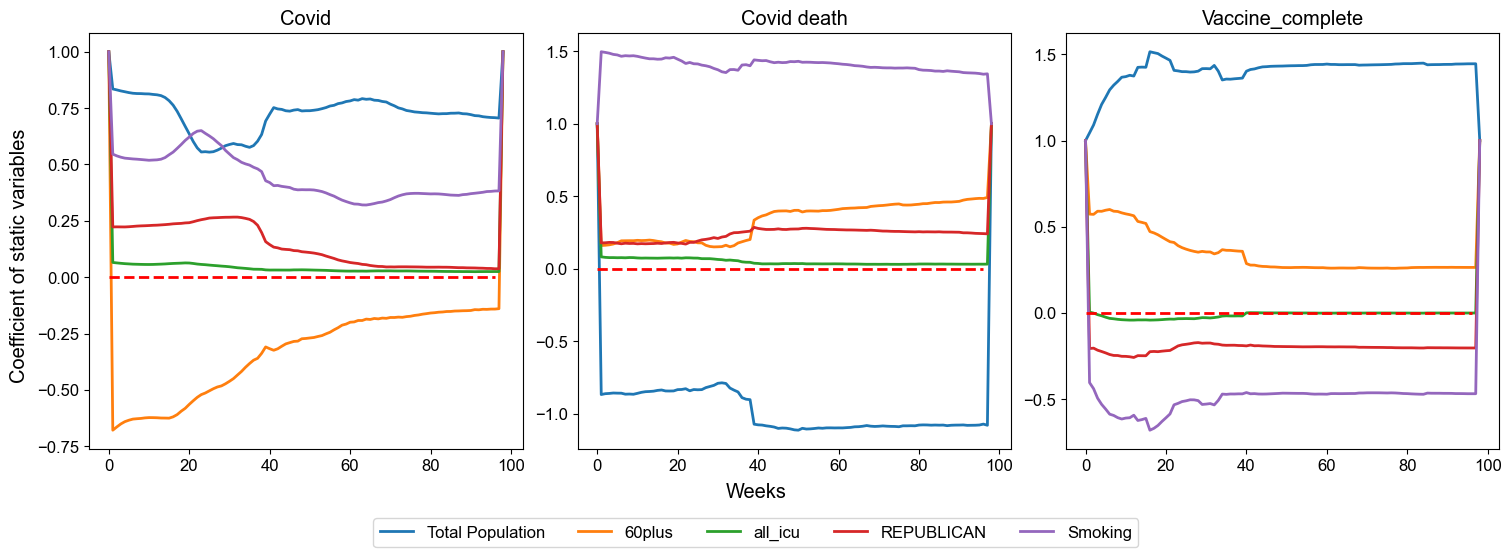

In [38]:
T = 100-1
index = ['Total Population','60plus','all_icu','REPUBLICAN','Smoking', ]

plt.rcParams.update({
    'font.size' : 12,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5),  sharex=True,constrained_layout=True)

for i in range(len(index)):
    # print(df_mix_msa.columns[-7:][i])
    axes[0].plot(range(T),FAMIs_covid_weekly_cum_static[i,:],label=index[i])
axes[0].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# plt.xticks(range(0,T-3,10),[dataset.columns[t+1][:-2] for t in range(0,T-3,10)],rotation=90)
# axes[0].set_xticks(range(0,T,5),range(0,T,5))
# axes[0].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# axes[0, 0].set_xlabel('Days')
# axes[0, 0].set_ylabel('Coefficient of static variables')
axes[0].set_title('Covid')
# axes[0, 0].legend()
# plt.show()

for i in range(len(index)):
    # print(df_mix_msa.columns[-7:][i])
    axes[1].plot(range(T),FAMIs_death_weekly_cum_static[i,:],label=index[i])
axes[1].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# plt.xticks(range(0,T-3,10),[dataset.columns[t+1][:-2] for t in range(0,T-3,10)],rotation=90)
# axes[1].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# axes[0, 1].set_xlabel('Days')
# axes[0, 1].set_ylabel('Coefficient of static variables')
axes[1].set_title('Covid death')

# for i in range(len(index)):
#     # print(df_mix_msa.columns[-7:][i])
#     axes[1, 0].plot(range(T),SCAMIs_vaccine_dose1_static[i,:],label=index[i])
# # plt.hlines(y=0,xmin=0,xmax=T,linestyles='--',colors='r',label='y=0')
# axes[1, 0].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# axes[1, 0].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# # axes[1, 0].set_xlabel('Days')
# # axes[1, 0].set_ylabel('Coefficient of static variables')
# axes[1, 0].set_title('Vaccine_dose1')
# # plt.legend()
# # plt.show()

for i in range(len(index)):
    # print(df_mix_msa.columns[-7:][i])
    axes[2].plot(range(T),FAMIs_vaccine_weekly_cum_static[i,:],label=index[i])
# plt.hlines(y=0,xmin=0,xmax=T,linestyles='--',colors='r',label='y=0')
axes[2].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# axes[2].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# axes[1, 1].set_xlabel('Days')
# axes[1, 1].set_ylabel('Coefficient of static variables')
axes[2].set_title('Vaccine_complete')

# lines_labels = [ax.get_legend_handles_labels() for ax in axes[0,0]]
# lines, labels = [sum(lol, []) for lol in zip(*index)]
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.supylabel('Coefficient of static variables')
fig.supxlabel("Weeks")
fig.legend( labels=index, loc = 'lower center', bbox_to_anchor = (0, -0.1, 1, 1),ncol=7)

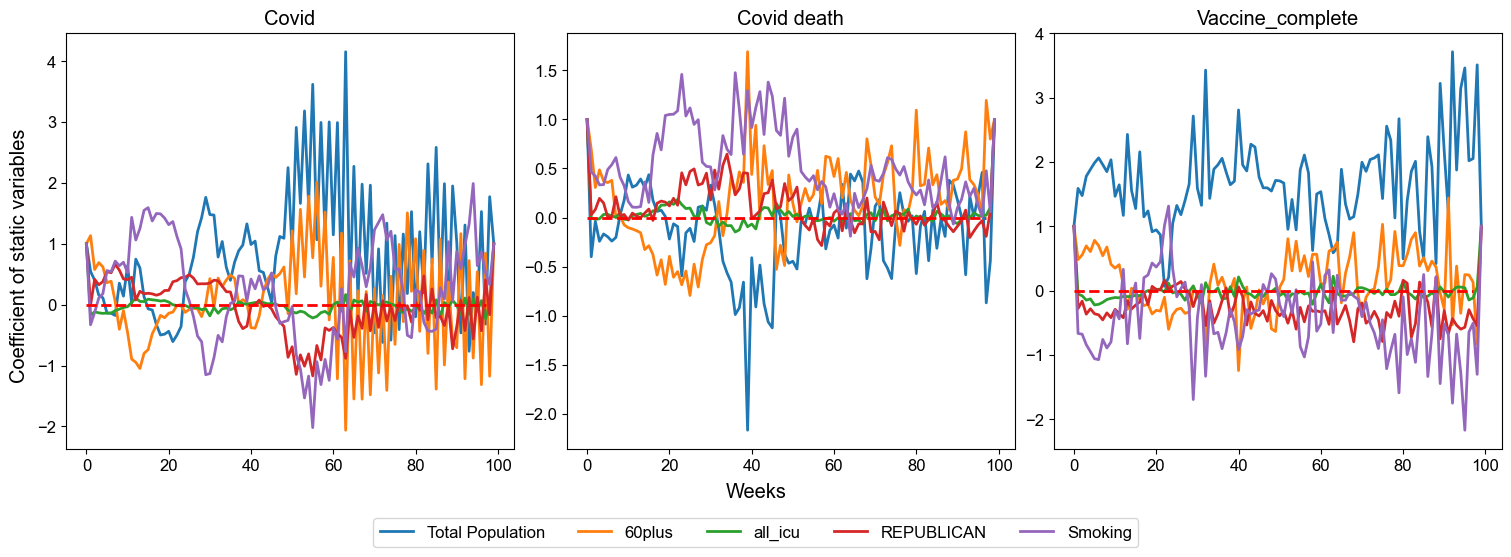

In [33]:
T = 100
index = ['Total Population','60plus','all_icu','REPUBLICAN','Smoking',]

plt.rcParams.update({
    'font.size' : 12,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5),  sharex=True,constrained_layout=True)

for i in range(len(index)):
    # print(df_mix_msa.columns[-7:][i])
    axes[0].plot(range(T),FAMIs_covid_weekly_static[i,:],label=index[i])
axes[0].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# plt.xticks(range(0,T-3,10),[dataset.columns[t+1][:-2] for t in range(0,T-3,10)],rotation=90)
# axes[0].set_xticks(range(0,T,5),range(0,T,5))
# axes[0].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# axes[0, 0].set_xlabel('Days')
# axes[0, 0].set_ylabel('Coefficient of static variables')
axes[0].set_title('Covid')
# axes[0, 0].legend()
# plt.show()

for i in range(len(index)):
    # print(df_mix_msa.columns[-7:][i])
    axes[1].plot(range(T),FAMIs_death_weekly_static[i,:],label=index[i])
axes[1].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# plt.xticks(range(0,T-3,10),[dataset.columns[t+1][:-2] for t in range(0,T-3,10)],rotation=90)
# axes[1].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# axes[0, 1].set_xlabel('Days')
# axes[0, 1].set_ylabel('Coefficient of static variables')
axes[1].set_title('Covid death')

# for i in range(len(index)):
#     # print(df_mix_msa.columns[-7:][i])
#     axes[1, 0].plot(range(T),SCAMIs_vaccine_dose1_static[i,:],label=index[i])
# # plt.hlines(y=0,xmin=0,xmax=T,linestyles='--',colors='r',label='y=0')
# axes[1, 0].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# axes[1, 0].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# # axes[1, 0].set_xlabel('Days')
# # axes[1, 0].set_ylabel('Coefficient of static variables')
# axes[1, 0].set_title('Vaccine_dose1')
# # plt.legend()
# # plt.show()

for i in range(len(index)):
    # print(df_mix_msa.columns[-7:][i])
    axes[2].plot(range(T),FAMIs_vaccine_weekly_static[i,:],label=index[i])
# plt.hlines(y=0,xmin=0,xmax=T,linestyles='--',colors='r',label='y=0')
axes[2].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# axes[2].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# axes[1, 1].set_xlabel('Days')
# axes[1, 1].set_ylabel('Coefficient of static variables')
axes[2].set_title('Vaccine_complete')

# lines_labels = [ax.get_legend_handles_labels() for ax in axes[0,0]]
# lines, labels = [sum(lol, []) for lol in zip(*index)]
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.supylabel('Coefficient of static variables')
fig.supxlabel("Weeks")
fig.legend( labels=index, loc = 'lower center', bbox_to_anchor = (0, -0.1, 1, 1),ncol=7)

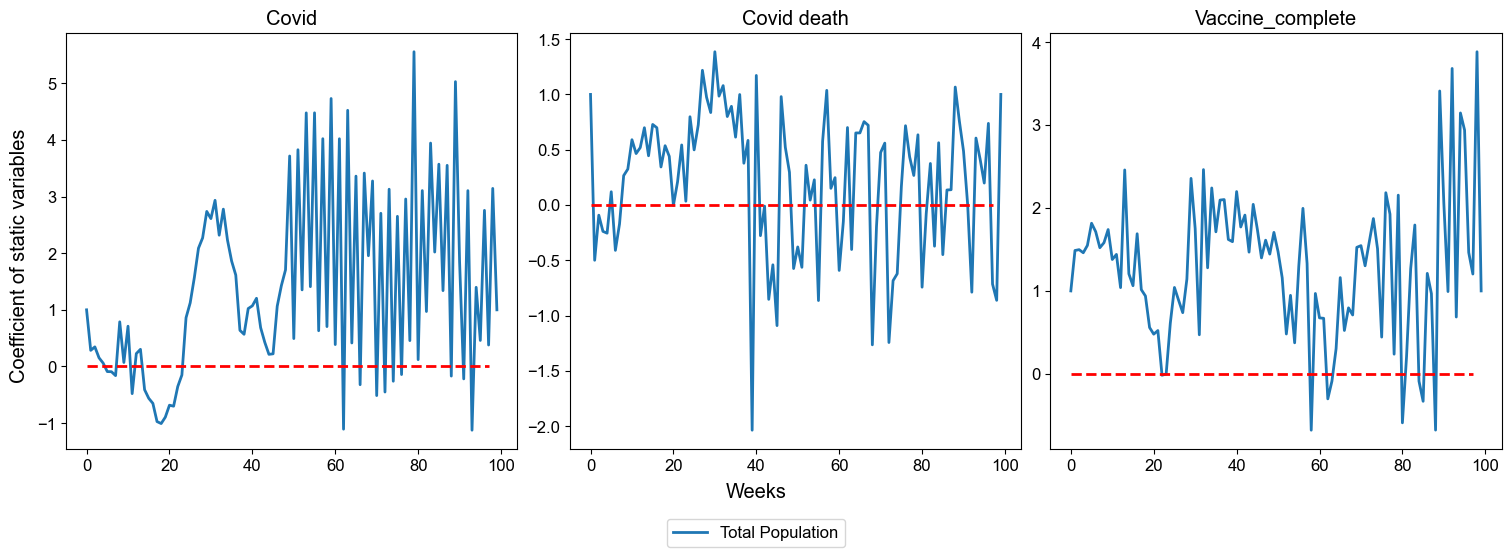

In [59]:
T = 100

plt.rcParams.update({
    'font.size' : 12,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5),  sharex=True,constrained_layout=True)

for i in range(len(index)):
    # print(df_mix_msa.columns[-7:][i])
    axes[0].plot(range(T),FAMIs_covid_weekly_static[i,:],label=index[i])
axes[0].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# plt.xticks(range(0,T-3,10),[dataset.columns[t+1][:-2] for t in range(0,T-3,10)],rotation=90)
# axes[0].set_xticks(range(0,T,5),range(0,T,5))
# axes[0].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# axes[0, 0].set_xlabel('Days')
# axes[0, 0].set_ylabel('Coefficient of static variables')
axes[0].set_title('Covid')
# axes[0, 0].legend()
# plt.show()

for i in range(len(index)):
    # print(df_mix_msa.columns[-7:][i])
    axes[1].plot(range(T),FAMIs_death_weekly_static[i,:],label=index[i])
axes[1].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# plt.xticks(range(0,T-3,10),[dataset.columns[t+1][:-2] for t in range(0,T-3,10)],rotation=90)
# axes[1].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# axes[0, 1].set_xlabel('Days')
# axes[0, 1].set_ylabel('Coefficient of static variables')
axes[1].set_title('Covid death')

# for i in range(len(index)):
#     # print(df_mix_msa.columns[-7:][i])
#     axes[1, 0].plot(range(T),SCAMIs_vaccine_dose1_static[i,:],label=index[i])
# # plt.hlines(y=0,xmin=0,xmax=T,linestyles='--',colors='r',label='y=0')
# axes[1, 0].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# axes[1, 0].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# # axes[1, 0].set_xlabel('Days')
# # axes[1, 0].set_ylabel('Coefficient of static variables')
# axes[1, 0].set_title('Vaccine_dose1')
# # plt.legend()
# # plt.show()

for i in range(len(index)):
    # print(df_mix_msa.columns[-7:][i])
    axes[2].plot(range(T),FAMIs_vaccine_weekly_static[i,:],label=index[i])
# plt.hlines(y=0,xmin=0,xmax=T,linestyles='--',colors='r',label='y=0')
axes[2].hlines(y=0,xmin=0,xmax=T-3,linestyles='--',colors='r',label='y=0')
# axes[2].set_xticks(range(0,T,50),[dataset.columns[4*t+7][:-6] for t in range(0,T,50)],rotation=90)
# axes[1, 1].set_xlabel('Days')
# axes[1, 1].set_ylabel('Coefficient of static variables')
axes[2].set_title('Vaccine_complete')

# lines_labels = [ax.get_legend_handles_labels() for ax in axes[0,0]]
# lines, labels = [sum(lol, []) for lol in zip(*index)]
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.supylabel('Coefficient of static variables')
fig.supxlabel("Weeks")
fig.legend( labels=index, loc = 'lower center', bbox_to_anchor = (0, -0.1, 1, 1),ncol=7)


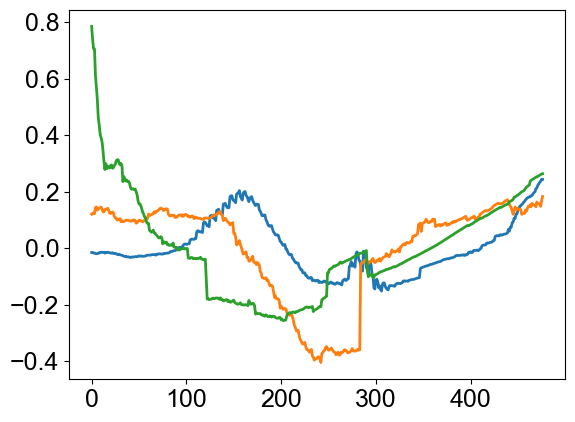

In [125]:
plt.rcParams.update({
    'font.size' : 18,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })


# plt.plot(range(T), SCAMIs_covid[0,:])
plt.plot(range(T),np.array([detrend(SCAMIs_covid[n,:]) for n in range(N)])[0,:])
plt.plot(range(T),detrend(SCAMIs_death[0,:]))
plt.plot(range(T),detrend(SCAMIs_vaccine_complete[0,:]))

In [90]:
T = int(len(dataset.columns[7:-158])/4)
t = 0
for t in range(T):
    print(4*t+7)
    print(dataset.columns[4*t+7])

7
4/3/21_covid
11
4/4/21_covid
15
4/5/21_covid
19
4/6/21_covid
23
4/7/21_covid
27
4/8/21_covid
31
4/9/21_covid
35
4/10/21_covid
39
4/11/21_covid
43
4/12/21_covid
47
4/13/21_covid
51
4/14/21_covid
55
4/15/21_covid
59
4/16/21_covid
63
4/17/21_covid
67
4/18/21_covid
71
4/19/21_covid
75
4/20/21_covid
79
4/21/21_covid
83
4/22/21_covid
87
4/23/21_covid
91
4/24/21_covid
95
4/25/21_covid
99
4/26/21_covid
103
4/27/21_covid
107
4/28/21_covid
111
4/29/21_covid
115
4/30/21_covid
119
5/1/21_covid
123
5/2/21_covid
127
5/3/21_covid
131
5/4/21_covid
135
5/5/21_covid
139
5/6/21_covid
143
5/7/21_covid
147
5/8/21_covid
151
5/9/21_covid
155
5/10/21_covid
159
5/11/21_covid
163
5/12/21_covid
167
5/13/21_covid
171
5/14/21_covid
175
5/15/21_covid
179
5/16/21_covid
183
5/17/21_covid
187
5/18/21_covid
191
5/19/21_covid
195
5/20/21_covid
199
5/21/21_covid
203
5/22/21_covid
207
5/23/21_covid
211
5/24/21_covid
215
5/25/21_covid
219
5/26/21_covid
223
5/27/21_covid
227
5/28/21_covid
231
5/29/21_covid
235
5/30/21_cov

In [7]:
dataset = pd.read_csv('df_mix_msa_weekly.csv')
dataset

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,index,Unnamed: 0.1,cbsa10,Unnamed: 0,FIPS,Total Population_x,4/3/21_covid,...,4/9/22_complete_weekly_incre,4/16/22_complete_weekly_incre,4/23/22_complete_weekly_incre,4/30/22_complete_weekly_incre,5/7/22_complete_weekly_incre,5/14/22_complete_weekly_incre,5/21/22_complete_weekly_incre,5/28/22_complete_weekly_incre,6/4/22_complete_weekly_incre,6/11/22_complete_weekly_incre
0,0,0,0,0,0,C1010,3149,92058.0,43191,5824,...,47.0,47.0,90.0,68.0,42.0,70.0,24.0,73.0,26.0,54.0
1,1,1,1,1,2,C1022,1450,40123.0,38247,5037,...,32.0,35.0,34.0,25.0,32.0,23.0,20.0,33.0,18.0,20.0
2,2,2,2,2,4,C1042,781,78286.0,704845,55572,...,565.0,532.0,427.0,468.0,426.0,2615.0,533.0,474.0,317.0,-1085.0
3,3,3,3,3,5,C1046,2082,35035.0,66781,3649,...,88.0,76.0,74.0,90.0,67.0,70.0,62.0,75.0,70.0,80.0
4,4,4,4,4,6,C1048,6284,24047.0,28711,2053,...,27.0,15.0,17.0,17.0,17.0,23.0,33.0,8.0,24.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,689,689,756,756,833,C4946,331,46135.0,22869,2946,...,47.0,68.0,43.0,56.0,50.0,33.0,25.0,24.0,20.0,32.0
690,690,690,757,757,834,C4962,1417,42133.0,448273,40395,...,715.0,587.0,542.0,538.0,469.0,508.0,463.0,402.0,448.0,450.0
691,691,691,758,758,835,C4966,4593,78254.0,428269,35508,...,389.0,400.0,349.0,286.0,290.0,1348.0,364.0,273.0,159.0,-517.0
692,692,692,759,759,836,C4970,3578,12216.0,174848,15064,...,150.0,183.0,494.0,171.0,122.0,227.0,99.0,100.0,100.0,115.0


In [3]:
t = 1
while t <= 433:
    print(dataset.columns[4*t+4+7*4],dataset.columns[4*t+4])
    col = dataset.columns[4*t+4+7*4]+'_weekly_incre'
    daily_increase = dataset.iloc[:, 4*t+4+7*4] - dataset.iloc[:, 4*t+4]
    dataset[col] = daily_increase
    t+=7
dataset

4/10/21_covid 4/3/21_covid
4/17/21_covid 4/10/21_covid
4/24/21_covid 4/17/21_covid
5/1/21_covid 4/24/21_covid
5/8/21_covid 5/1/21_covid
5/15/21_covid 5/8/21_covid
5/22/21_covid 5/15/21_covid
5/29/21_covid 5/22/21_covid
6/5/21_covid 5/29/21_covid
6/12/21_covid 6/5/21_covid
6/19/21_covid 6/12/21_covid
6/26/21_covid 6/19/21_covid
7/3/21_covid 6/26/21_covid
7/10/21_covid 7/3/21_covid
7/17/21_covid 7/10/21_covid
7/24/21_covid 7/17/21_covid
7/31/21_covid 7/24/21_covid
8/7/21_covid 7/31/21_covid
8/14/21_covid 8/7/21_covid
8/21/21_covid 8/14/21_covid
8/28/21_covid 8/21/21_covid
9/4/21_covid 8/28/21_covid
9/11/21_covid 9/4/21_covid
9/18/21_covid 9/11/21_covid
9/25/21_covid 9/18/21_covid
10/2/21_covid 9/25/21_covid
10/9/21_covid 10/2/21_covid
10/16/21_covid 10/9/21_covid
10/23/21_covid 10/16/21_covid
10/30/21_covid 10/23/21_covid
11/6/21_covid 10/30/21_covid
11/13/21_covid 11/6/21_covid
11/20/21_covid 11/13/21_covid
11/27/21_covid 11/20/21_covid
12/4/21_covid 11/27/21_covid
12/11/21_covid 12/4/2

,Unnamed: 0.3,Unnamed: 0.2,index,Unnamed: 0.1,cbsa10,Unnamed: 0,FIPS,Total Population_x,4/3/21_covid,4/3/21_death,...,4/9/22_covid_weekly_incre,4/16/22_covid_weekly_incre,4/23/22_covid_weekly_incre,4/30/22_covid_weekly_incre,5/7/22_covid_weekly_incre,5/14/22_covid_weekly_incre,5/21/22_covid_weekly_incre,5/28/22_covid_weekly_incre,6/4/22_covid_weekly_incre,6/11/22_covid_weekly_incre
0,0,0,0,0,C1010,3149,92058.0,43191,5824,104,...,12,5,10,19,9,22,15,26,18,25
1,1,1,1,2,C1022,1450,40123.0,38247,5037,50,...,42,34,10,16,29,11,15,10,27,45
2,2,2,2,4,C1042,781,78286.0,704845,55572,1137,...,175,304,487,609,965,1401,1592,1606,1097,1099
3,3,3,3,5,C1046,2082,35035.0,66781,3649,72,...,24,25,6,3,26,35,30,54,54,107
4,4,4,4,6,C1048,6284,24047.0,28711,2053,42,...,5,14,8,11,8,22,43,71,105,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,689,756,756,833,C4946,331,46135.0,22869,2946,28,...,2,1,2,5,6,13,10,24,15,14
690,690,757,757,834,C4962,1417,42133.0,448273,40395,752,...,152,221,259,404,240,643,845,980,842,713
691,691,758,758,835,C4966,4593,78254.0,428269,35508,1067,...,122,95,197,206,265,421,703,840,727,684
692,692,759,759,836,C4970,3578,12216.0,174848,15064,149,...,36,53,24,87,133,95,343,363,360,454


In [4]:
t = 1
while t <= 433:
    print(dataset.columns[4*t+5+7*4],dataset.columns[4*t+5])
    col = dataset.columns[4*t+5+7*4]+'_weekly_incre'
    daily_increase = dataset.iloc[:, 4*t+5+7*4] -  dataset.iloc[:, 4*t+5]
    dataset[col] = daily_increase
    t+=7
dataset

4/10/21_death 4/3/21_death
4/17/21_death 4/10/21_death
4/24/21_death 4/17/21_death
5/1/21_death 4/24/21_death
5/8/21_death 5/1/21_death
5/15/21_death 5/8/21_death
5/22/21_death 5/15/21_death
5/29/21_death 5/22/21_death
6/5/21_death 5/29/21_death
6/12/21_death 6/5/21_death
6/19/21_death 6/12/21_death
6/26/21_death 6/19/21_death
7/3/21_death 6/26/21_death
7/10/21_death 7/3/21_death
7/17/21_death 7/10/21_death
7/24/21_death 7/17/21_death
7/31/21_death 7/24/21_death
8/7/21_death 7/31/21_death
8/14/21_death 8/7/21_death
8/21/21_death 8/14/21_death
8/28/21_death 8/21/21_death
9/4/21_death 8/28/21_death
9/11/21_death 9/4/21_death
9/18/21_death 9/11/21_death
9/25/21_death 9/18/21_death
10/2/21_death 9/25/21_death
10/9/21_death 10/2/21_death
10/16/21_death 10/9/21_death
10/23/21_death 10/16/21_death
10/30/21_death 10/23/21_death
11/6/21_death 10/30/21_death
11/13/21_death 11/6/21_death
11/20/21_death 11/13/21_death
11/27/21_death 11/20/21_death
12/4/21_death 11/27/21_death
12/11/21_death 12/4/2

/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_79340/2949569989.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[col] = daily_increase
/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_79340/2949569989.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[col] = daily_increase
/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_79340/2949569989.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

,Unnamed: 0.3,Unnamed: 0.2,index,Unnamed: 0.1,cbsa10,Unnamed: 0,FIPS,Total Population_x,4/3/21_covid,4/3/21_death,...,4/9/22_death_weekly_incre,4/16/22_death_weekly_incre,4/23/22_death_weekly_incre,4/30/22_death_weekly_incre,5/7/22_death_weekly_incre,5/14/22_death_weekly_incre,5/21/22_death_weekly_incre,5/28/22_death_weekly_incre,6/4/22_death_weekly_incre,6/11/22_death_weekly_incre
0,0,0,0,0,C1010,3149,92058.0,43191,5824,104,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,2,C1022,1450,40123.0,38247,5037,50,...,2,1,0,2,2,1,1,0,0,2
2,2,2,2,4,C1042,781,78286.0,704845,55572,1137,...,2,3,1,2,3,1,3,5,7,4
3,3,3,3,5,C1046,2082,35035.0,66781,3649,72,...,2,1,1,2,0,0,1,0,0,1
4,4,4,4,6,C1048,6284,24047.0,28711,2053,42,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,689,756,756,833,C4946,331,46135.0,22869,2946,28,...,1,0,0,0,0,0,0,0,0,0
690,690,757,757,834,C4962,1417,42133.0,448273,40395,752,...,5,3,2,3,2,1,3,9,2,2
691,691,758,758,835,C4966,4593,78254.0,428269,35508,1067,...,3,0,3,3,1,3,1,4,2,3
692,692,759,759,836,C4970,3578,12216.0,174848,15064,149,...,2,1,0,0,2,1,0,1,0,1


In [10]:
dataset.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'index', 'Unnamed: 0.1', 'cbsa10',
       'Unnamed: 0', 'FIPS', 'Total Population_x', '4/3/21_covid',
       '4/3/21_death',
       ...
       '4/9/22_covid_weekly_incre', '4/16/22_covid_weekly_incre',
       '4/23/22_covid_weekly_incre', '4/30/22_covid_weekly_incre',
       '5/7/22_covid_weekly_incre', '5/14/22_covid_weekly_incre',
       '5/21/22_covid_weekly_incre', '5/28/22_covid_weekly_incre',
       '6/4/22_covid_weekly_incre', '6/11/22_covid_weekly_incre'],
      dtype='object', length=2174)

In [5]:
t = 1
while t <= 433:
    print(dataset.columns[4*t+6+7*4],dataset.columns[4*t+6])
    col = dataset.columns[4*t+6+7*4]+'_weekly_incre'
    daily_increase = dataset.iloc[:, 4*t+6+7*4] - dataset.iloc[:, 4*t+6]
    dataset[col] = daily_increase
    t+=7
dataset

4/10/21_complete 4/3/21_complete
4/17/21_complete 4/10/21_complete
4/24/21_complete 4/17/21_complete
5/1/21_complete 4/24/21_complete
5/8/21_complete 5/1/21_complete
5/15/21_complete 5/8/21_complete
5/22/21_complete 5/15/21_complete
5/29/21_complete 5/22/21_complete
6/5/21_complete 5/29/21_complete
6/12/21_complete 6/5/21_complete
6/19/21_complete 6/12/21_complete
6/26/21_complete 6/19/21_complete
7/3/21_complete 6/26/21_complete
7/10/21_complete 7/3/21_complete
7/17/21_complete 7/10/21_complete
7/24/21_complete 7/17/21_complete
7/31/21_complete 7/24/21_complete
8/7/21_complete 7/31/21_complete
8/14/21_complete 8/7/21_complete
8/21/21_complete 8/14/21_complete
8/28/21_complete 8/21/21_complete
9/4/21_complete 8/28/21_complete
9/11/21_complete 9/4/21_complete
9/18/21_complete 9/11/21_complete
9/25/21_complete 9/18/21_complete
10/2/21_complete 9/25/21_complete
10/9/21_complete 10/2/21_complete
10/16/21_complete 10/9/21_complete
10/23/21_complete 10/16/21_complete
10/30/21_complete 10/23/

/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_79340/2438786594.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[col] = daily_increase
/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_79340/2438786594.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[col] = daily_increase
/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_79340/2438786594.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

,Unnamed: 0.3,Unnamed: 0.2,index,Unnamed: 0.1,cbsa10,Unnamed: 0,FIPS,Total Population_x,4/3/21_covid,4/3/21_death,...,4/9/22_complete_weekly_incre,4/16/22_complete_weekly_incre,4/23/22_complete_weekly_incre,4/30/22_complete_weekly_incre,5/7/22_complete_weekly_incre,5/14/22_complete_weekly_incre,5/21/22_complete_weekly_incre,5/28/22_complete_weekly_incre,6/4/22_complete_weekly_incre,6/11/22_complete_weekly_incre
0,0,0,0,0,C1010,3149,92058.0,43191,5824,104,...,47.0,47.0,90.0,68.0,42.0,70.0,24.0,73.0,26.0,54.0
1,1,1,1,2,C1022,1450,40123.0,38247,5037,50,...,32.0,35.0,34.0,25.0,32.0,23.0,20.0,33.0,18.0,20.0
2,2,2,2,4,C1042,781,78286.0,704845,55572,1137,...,565.0,532.0,427.0,468.0,426.0,2615.0,533.0,474.0,317.0,-1085.0
3,3,3,3,5,C1046,2082,35035.0,66781,3649,72,...,88.0,76.0,74.0,90.0,67.0,70.0,62.0,75.0,70.0,80.0
4,4,4,4,6,C1048,6284,24047.0,28711,2053,42,...,27.0,15.0,17.0,17.0,17.0,23.0,33.0,8.0,24.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,689,756,756,833,C4946,331,46135.0,22869,2946,28,...,47.0,68.0,43.0,56.0,50.0,33.0,25.0,24.0,20.0,32.0
690,690,757,757,834,C4962,1417,42133.0,448273,40395,752,...,715.0,587.0,542.0,538.0,469.0,508.0,463.0,402.0,448.0,450.0
691,691,758,758,835,C4966,4593,78254.0,428269,35508,1067,...,389.0,400.0,349.0,286.0,290.0,1348.0,364.0,273.0,159.0,-517.0
692,692,759,759,836,C4970,3578,12216.0,174848,15064,149,...,150.0,183.0,494.0,171.0,122.0,227.0,99.0,100.0,100.0,115.0


In [27]:
dataset.columns[1925+62:1925+62+62].tolist()

['10/2/21_death_weekly',
 '10/9/21_death_weekly',
 '10/16/21_death_weekly',
 '10/23/21_death_weekly',
 '10/30/21_death_weekly',
 '11/6/21_death_weekly',
 '11/13/21_death_weekly',
 '11/20/21_death_weekly',
 '11/27/21_death_weekly',
 '12/4/21_death_weekly',
 '12/11/21_death_weekly',
 '12/18/21_death_weekly',
 '12/25/21_death_weekly',
 '1/1/22_death_weekly',
 '1/8/22_death_weekly',
 '1/15/22_death_weekly',
 '1/22/22_death_weekly',
 '1/29/22_death_weekly',
 '2/5/22_death_weekly',
 '2/12/22_death_weekly',
 '2/19/22_death_weekly',
 '2/26/22_death_weekly',
 '3/5/22_death_weekly',
 '3/12/22_death_weekly',
 '3/19/22_death_weekly',
 '3/26/22_death_weekly',
 '4/2/22_death_weekly',
 '4/9/22_death_weekly',
 '4/16/22_death_weekly',
 '4/23/22_death_weekly',
 '4/30/22_death_weekly',
 '5/7/22_death_weekly',
 '5/14/22_death_weekly',
 '5/21/22_death_weekly',
 '5/28/22_death_weekly',
 '6/4/22_death_weekly',
 '6/11/22_death_weekly',
 '4/10/21_complete_weekly',
 '4/17/21_complete_weekly',
 '4/24/21_complete

In [9]:
dataset.columns[1925+0]

'60minus'

In [6]:
dataset.to_csv('df_mix_msa_weekly.csv')

ValueError: x and y must have same first dimension, but have shapes (477,) and (1,)

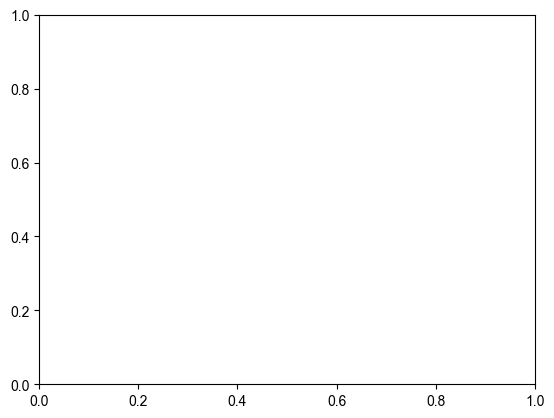

In [31]:
plt.rcParams.update({
    'font.size' : 10,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })


# plt.plot(range(T), SCAMIs_covid[0,:])
for i in range(static_variables.shape[1]):
    plt.plot(range(T),dataset.iloc[i,4*t+7], label = index[i])
# plt.ylim(0,1)
plt.legend()

In [180]:
MI_SAMIs_covid[0,100:120]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0078288 , 0.00917995, 0.00588823, 0.00050709,
       0.        , 0.        , 0.        , 0.        , 0.01022458])

1.0000000000000009
correlation 0.8136244077765526 3.8280497628781185e-165


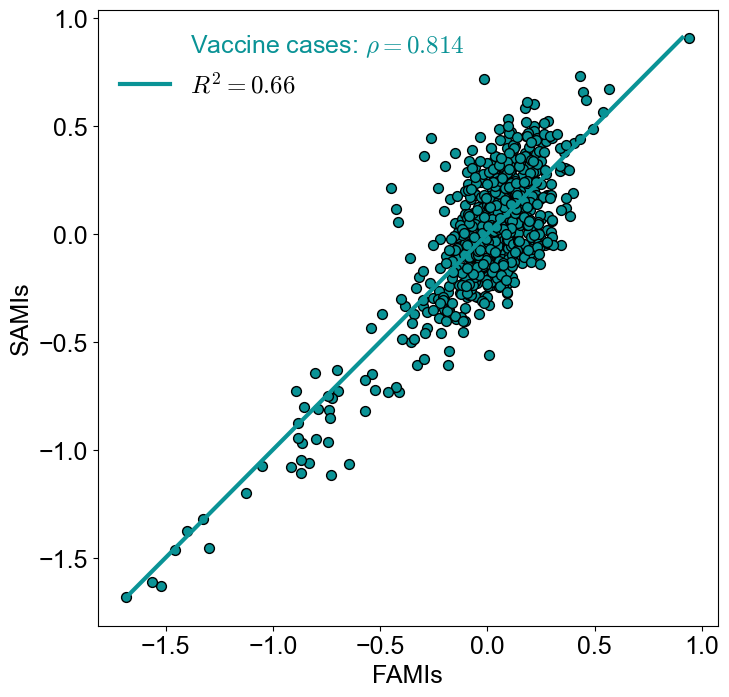

In [30]:
def linear_regression(x,y):
    X = sm.add_constant(x)
    model = sm.OLS(y,X).fit()
    intercept, slope = model.params
    y_pred = intercept  + slope*x
    R2 = str(round(model.rsquared,2))

    x_0 =  np.sort(x)[0]
    y_0 = slope*x_0+intercept

    print(slope)

    x_f = np.sort(y)[-1]
    y_f = slope*x_f+intercept

    print('correlation',pearsonr(x,y)[0], pearsonr(x,y)[1])


    plt.rcParams.update({
    'font.size' : 18,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })
    cl = ["#ae2012","#403d39","#0a9396"]
    # cl = ["#ffbf69","#6b9080"]
    fig, (ax) = plt.subplots(1,1, figsize=(8,8))
    ax.plot([], [], ' ', label=r'{}: $\rho = {}$'.format(r'Vaccine cases', str(np.round(pearsonr(x,y)[0], 3))))
    ax.scatter(x,y,facecolors=cl[2], edgecolors='k',s=50)
    ax.plot([x_0,x_f],[y_0,y_f], lw = 3, color = cl[2],label=r'$\mathit{R}^2 = $' +r'${}$'.format(str(R2)))
    ax.set_xlabel('FAMIs')
    ax.set_ylabel("SAMIs")
    leg = ax.legend(loc='upper left', frameon=False)
    text = leg.get_texts()[0]
    text.set_color(cl[2])
t = 100
# for t in range(T):
linear_regression(SCAMIs_vaccine_complete[:,t],SAMIs_vaccine_complete[:,t])

In [25]:
np.save('FAMIs_covid.npy', SCAMIs_covid)
np.save('FAMIs_death.npy', SCAMIs_death)
np.save('FAMIs_vaccine_dose1.npy', SCAMIs_vaccine_dose1)
np.save('FAMIs_vaccine.npy', SCAMIs_vaccine_complete)


np.save('SAMIs_covid.npy', SAMIs_covid)
np.save('SAMIs_death.npy', SAMIs_death)
np.save('SAMIs_vaccine_dose1.npy', SAMIs_vaccine_dose1)
np.save('SAMIs_vaccine.npy', SAMIs_vaccine_complete)



In [24]:
pd.DataFrame({'FAMIs_covid':SCAMIs_covid, 'FAMIs_death':SCAMIs_death, 'FAMIs_vaccine':SCAMIs_vaccine_complete, 'FAMIs_vaccine_dose1':SCAMIs_vaccine_dose1})

ValueError: Per-column arrays must each be 1-dimensional

In [228]:
cl = ["#ae2012","#403d39","#0081a7"]
cl[2]

'#0081a7'

Text(0, 0.5, 'SAMIs')

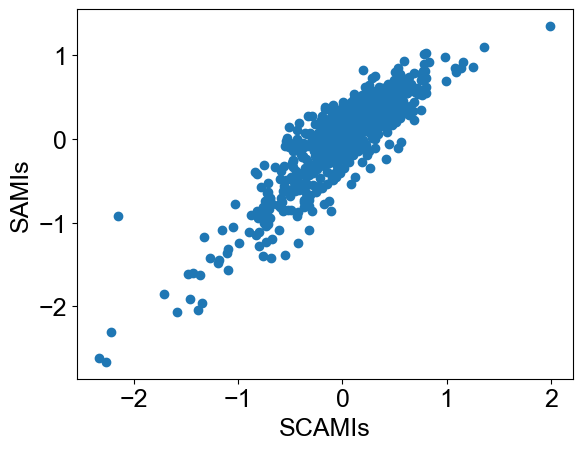

In [193]:


t = 100
plt.scatter(SCAMIs_death[:,t],SAMIs_death[:,t])
X = sm.add_constant(x)
# print(X.shape,y.shape)
model = sm.OLS(y, X).fit()
plt.xlabel('SCAMIs')
plt.ylabel("SAMIs")

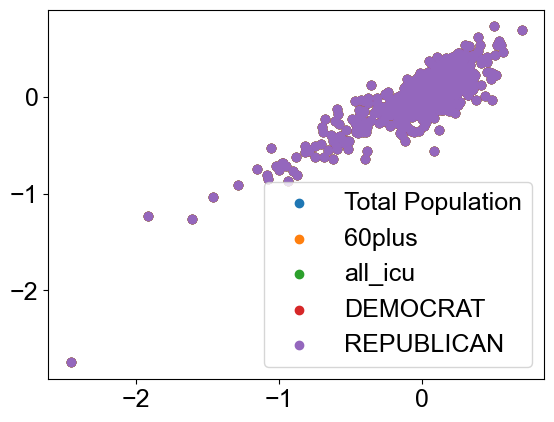

In [185]:
plt.rcParams.update({
    'font.size' : 18,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })

for i in range(len(index)):
    plt.scatter(SAMIs_covid[:,120],SCAMIs_covid[:,120], label = index[i])
plt.legend()

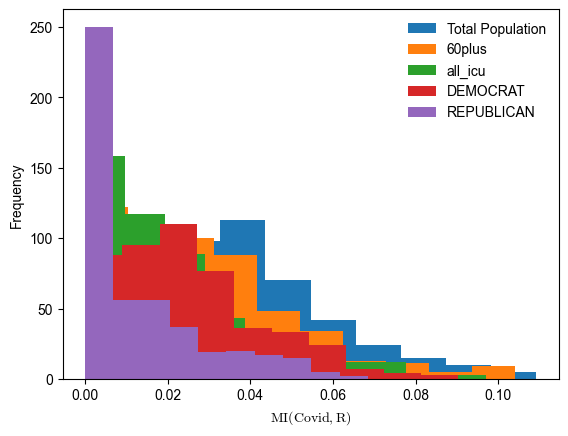

In [240]:
plt.rcParams.update({
    'font.size' : 10,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })


# plt.plot(range(T), SCAMIs_covid[0,:])
for i in range(static_variables.shape[1]):
    plt.hist(MI_SCAMIs_covid[i], label = index[i])
# plt.ylim(0,1)
plt.xlabel('$MI(Covid, R)$')
plt.ylabel('Frequency')
plt.legend(frameon=False)
# plt.plot(range(T),detrend(SCAMIs_death[0,:]))
# plt.plot(range(T),detrend(SCAMIs_vaccine_complete[0,:]))


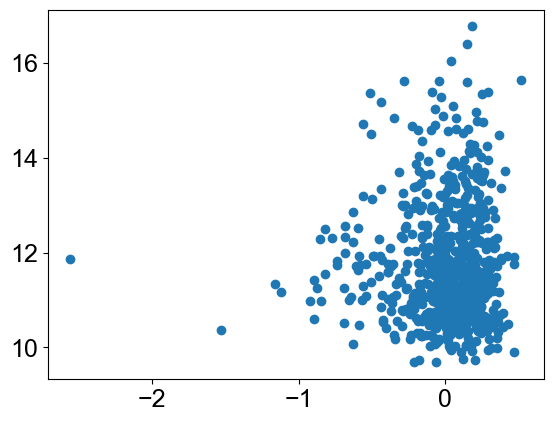

In [224]:
plt.scatter(SAMIs_covid[:,t],np.log(static_variables[:,0]), label = index[0])

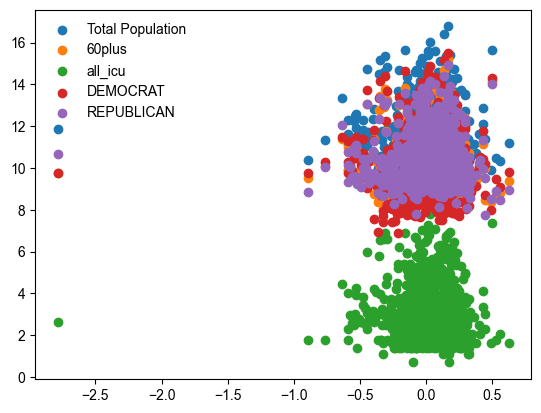

In [237]:
plt.rcParams.update({
    'font.size' : 10,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })

for i in range(len(index)):
    plt.scatter(SCAMIs_covid[:,t],np.log(static_variables[:,i]), label = index[i])
plt.legend( frameon=False)

In [279]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
adf_test(SCAMIs_covid[0,:])

Results of Dickey-Fuller Test:
Test Statistic                  -1.688282
p-value                          0.437160
#Lags Used                       8.000000
Number of Observations Used    468.000000
Critical Value (1%)             -3.444400
Critical Value (5%)             -2.867736
Critical Value (10%)            -2.570070
dtype: float64


In [259]:
N,T = SCAMIs_covid.shape

SCAMIs_covid_detrend = np.array([detrend(SCAMIs_covid[n,:]) for n in range(N)])
SCAMIs_death_detrend = np.array([detrend(SCAMIs_death[n,:]) for n in range(N)])
SCAMIs_vaccine_complete_detrend = np.array([detrend(SCAMIs_vaccine_complete[n,:]) for n in range(N)])


In [260]:


array = np.zeros((N,3,T), dtype=float)
array[:,0,:] = SCAMIs_covid_detrend
array[:,1,:] = SCAMIs_death_detrend
array[:,2,:] = SCAMIs_vaccine_complete_detrend

cmi = CMI_KNN(array=array, knn=5, time_lag=5)

N,dim,t = array.shape
r = 0
# constraint_dim = constraint.shape[1]
# while r<dim-1:
# for target in list(combinations(range(dim),2)):
for x in range(dim):
    for y in range(dim):              
        if x!=y:
            
            # z_all = list(combinations(np.delete(range(dim),target),r))
            # for Z in z_all:
            # x,y = target
            xyz = [[x],[y],[]]
            print(x,y,xyz)
            # xyz = [[x],[y],list(Z)]
            XYZ,te_xy = cmi.independence_measure(xyz)
            # TE_XY_XI[m1,m2] = te_xy
            pcorr_xy, pcorr_pval_xy = partial_corr(XYZ)
            pval_xy = cmi.parallel_shuffles_significance(xyz)
            # PVALUE_XY[m1,m2] = pval_xy
            # print(xyz, te_xy)
            print(xyz, te_xy, pval_xy,)
            print(pcorr_xy,pcorr_pval_xy)

0 1 [[0], [1], []]


/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_33761/2995968621.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  P_corr = np.zeros((p, p), dtype=np.float)
/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_33761/2995968621.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  P_value = np.zeros((p, p), dtype=np.floa

[[0], [1], []] 0.13751654307190164 0.0
0.15866630739371002 0.0
0 2 [[0], [2], []]
[[0], [2], []] 0.11467122005545827 0.0
0.031359956604340364 4.565935105152957e-72
1 0 [[1], [0], []]
[[1], [0], []] 0.11522723246440703 0.0
-0.09825599128951176 0.0
1 2 [[1], [2], []]
[[1], [2], []] 0.10922137785037744 0.0
0.02178613675157477 1.0826312786610752e-35
2 0 [[2], [0], []]
[[2], [0], []] 0.10271712347790807 0.0
-0.04488247538032096 1.148316631513244e-145
2 1 [[2], [1], []]
[[2], [1], []] 0.10467312515262961 0.0
0.00046913494986320183 0.7883132379247256


In [276]:
import scipy.io
xi = scipy.io.loadmat('/Users/tg2426/Documents/Python/Covid/Synthetic_Results/case7.mat')
A = xi['A']
print(xi['gamma_x'],xi['gamma_y'])
XI_X = xi['XI_X']
XI_Y = xi['XI_Y']

ZETA_X = xi['ZETA_X']
ZETA_Y = xi['ZETA_Y']

BETA_X = xi['BETA_X']
BETA_Y = xi['BETA_Y']

[[0]] [[0]]


In [7]:
def convert_to_string_graph(graph_bool):
    """Converts the 0,1-based graph returned by PCMCI to a string array
    with links '-->'.

    Parameters
    ----------
    graph_bool : array
        0,1-based graph array output by PCMCI.

    Returns
    -------
    graph : array
        graph as string array with links '-->'.
    """

    graph = np.zeros(graph_bool.shape, dtype='<U3')
    graph[:] = ""
    # Lagged links
    graph[:,:,1:][graph_bool[:,:,1:]==1] = "-->"
    # Unoriented contemporaneous links
    graph[:,:,0][np.logical_and(graph_bool[:,:,0]==1, 
                                graph_bool[:,:,0].T==1)] = "o-o"
    # Conflicting contemporaneous links
    graph[:,:,0][np.logical_and(graph_bool[:,:,0]==2, 
                                graph_bool[:,:,0].T==2)] = "x-x"
    # Directed contemporaneous links
    for (i,j) in zip(*np.where(
        np.logical_and(graph_bool[:,:,0]==1, graph_bool[:,:,0].T==0))):
        graph[i,j,0] = "-->"
        graph[j,i,0] = "<--"

    return graph

In [25]:
import numpy as np
A = np.random.random((3,3,3))
B = A <=0.05
convert_to_string_graph(B)


array([[['', '-->', ''],
        ['', '', '-->'],
        ['', '', '']],

       [['', '', ''],
        ['', '', '-->'],
        ['', '', '-->']],

       [['', '', ''],
        ['', '', ''],
        ['o-o', '', '']]], dtype='<U3')

In [132]:
from scipy.stats.contingency import crosstab
n_symbs = 2
array = np.array([[0.5, 1, -0.5, 1.5, 1.2],[1.5, -0.1, 0, -0.3, -0.4],[1.5, 0.1, 0, -0.3, -0.4],])
array[array>=0] = 1
array[array<0] = -1
dim, T = array.shape
print(array.shape)
array


(1, 5)


array([[ 1.,  1., -1.,  1.,  1.]])

In [130]:
def joint_entropy(p): 
    """ 
    p: joint probability of (X,Y,Z,...) or probability of X
    """
    p = p[p!=0]/np.sum(p)
    print(p)
    return -np.sum(p*np.log(p))

In [133]:
# joint_set = np.array([array[:,t].tolist() for t in range(array.shape[1])])
# print(joint_set, joint_set.shape)
hist = crosstab(*array,).count.flatten()
print(hist)
joint_entropy(hist)


[1 4]
[0.2 0.8]


0.5004024235381879

In [100]:
crosstab(*np.array(joint_set).T, levels=np.tile(np.arange(n_symbs),((np.array(joint_set).T).shape[0],1)))

CrosstabResult(elements=[array([0, 1]), array([0, 1]), array([0, 1])], count=array([[[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 1]]]))

In [144]:
import pandas as pd
import numpy as np

# Sample 2D array
values = np.array([
    [0.5, 1, -0.5, 1.5, 1.2],
    [1.5, -0.1, 0, -0.3, -0.4],
    [1.5, 0.1, 0, -0.3, -0.4]
])

def bin_array(values):

    # Flatten the array to create a 1D array for binning
    flat_values = values.flatten()

    # Create a DataFrame from the flattened array
    df = pd.DataFrame({'Value': flat_values})

    # Define bin edges based on percentiles
    quantiles = [0, 0.3, 0.7, 1.0]
    bins = df['Value'].quantile(quantiles).values

    # Define bin labels
    labels = [1, 2, 3]

    # Create a new column 'Binned' with the bin labels based on quantiles
    df['Binned'] = pd.cut(df['Value'], bins=bins, labels=labels, include_lowest=True)
    df['Binned'] = df['Binned'].astype(int)
    # Reshape the binned values back to the original array shape
    symbolized_array = df['Binned'].values.reshape(values.shape)
    return symbolized_array
# symbolized_array
# Display the original and symbolized arrays
# print("Original Array:")
# print(values)
# print("\nSymbolized Array:")
print(symbolized_array)


[[2 3 1 3 3]
 [3 2 2 1 1]
 [3 2 2 1 1]]


In [159]:
import numpy as np

# Sample 2D array
# values = np.array([
#     [0.5, 1, -0.5, 1.5, 1.2],
#     [1.5, -0.1, 0, -0.3, -0.4],
#     [1.3, 0.1, 0, -0.2, -0.34]
# ])
values = np.random.normal(0, 1, (2,500))


# Flatten the array to create a 1D array for binning
flat_values = values.flatten()

# Define bin edges based on percentiles
percentiles = np.percentile(flat_values, [0, 33.3, 66.6, 100])

# Digitize the values into bins
binned_indices = np.digitize(flat_values, percentiles, right=True)

# Since digitize assigns bins from 1 to len(percentiles)-1, adjust to match label count
# If necessary, adjust indices to start from 1 for labels [1, 2, 3, 4]
# binned_indices = np.clip(binned_indices - 1, 1, 3)

# Reshape the binned indices back to the original array shape
symbolized_array = binned_indices.reshape(values.shape)

# Display the original and symbolized arrays
print("Original Array:")
print(values)
print("\nSymbolized Array:")
print(symbolized_array)


Original Array:
[[-3.89424558e-01  9.66141062e-01  3.80776502e-01  1.59945230e-02
  -9.98935108e-03  2.44234970e+00  8.42589832e-01 -8.08781753e-01
  -1.11135626e+00  1.12799506e+00 -1.65258956e-01 -5.65128066e-01
   1.27118520e+00  3.13569325e-01  1.24612986e+00 -7.55445066e-01
   2.33795304e-01  4.28049558e-01 -1.35691426e+00  1.03853023e-01
  -5.04382904e-01  8.07851864e-01 -9.23247838e-01  5.91286685e-01
   2.64761133e+00  9.14758667e-01 -1.16223820e+00 -7.45199415e-02
   2.43962394e-01  6.87620554e-01 -1.69519264e+00  1.13184009e+00
  -4.10258603e-02  8.44137360e-01  3.35385045e-01  1.19650700e+00
  -2.69128787e+00  5.15378455e-01 -4.44421481e-01 -3.15222237e-01
  -1.05255136e+00  2.65983537e-01 -9.84506499e-01  1.32690755e-01
   2.04484559e-01  3.45847459e-01 -5.40835753e-01 -1.42565387e+00
  -8.43003407e-01  3.48347515e-01  8.51509168e-01  7.26551925e-01
   1.42320839e+00  1.90751949e+00 -5.52952618e-02 -9.90842921e-01
   2.11293545e+00 -1.33999562e+00  2.37403576e-01 -1.1753353

In [79]:
print(np.tile(np.arange(n_symbs),(2,2)))

[[0 1 0 1]
 [0 1 0 1]]


In [98]:
xyz = [0, 1, 2]
levels = np.tile(np.arange(n_symbs), (len(xyz), 1))

# High-dimensional contingency table
_, hist = crosstab(*(np.asarray(np.split(array, len(xyz), axis=0)).reshape((-1, T))), levels=levels,
                    sparse=False)


def _plogp_vector(T):
    """Precalculation of p*log(p) needed for entropies."""
    gfunc = np.zeros(T + 1)
    data = np.arange(1, T + 1, 1)
    gfunc[1:] = data * np.log(data)
    def plogp_func(time):
        return gfunc[time]
    return np.vectorize(plogp_func)

# Dimensions are hist are (X, Y, Z^1, .... Z^dz)
# plogp = _plogp_vector(T)
# hxyz = (-(plogp(hist)).sum() + plogp(T)) / float(T)
# hxz = (-(plogp(hist.sum(axis=1))).sum() + plogp(T)) / float(T)
# hyz = (-(plogp(hist.sum(axis=0))).sum() + plogp(T)) / float(T)
# hz = (-(plogp(hist.sum(axis=0).sum(axis=0))).sum() + plogp(T)) / float(T)

# Multivariate X, Y version
plogp = _plogp_vector(T)
hxyz = (-(plogp(hist)).sum() + plogp(T)) / float(T)
hxz = (-(plogp(hist.sum(axis=tuple(np.where(xyz==1)[0])))).sum() + plogp(T)) / float(T)
hyz = (-(plogp(hist.sum(axis=tuple(np.where(xyz==0)[0])))).sum() + plogp(T)) / float(T)
hz = (-(plogp(hist.sum(axis=tuple(np.where((xyz==0) | (xyz==1))[0])))).sum() + plogp(T)) / float(T)
val = hxz + hyz - hz - hxyz
print(hxz,hyz,hxyz,hz)


1.3862943611198906 1.3862943611198906 1.3862943611198906 1.3862943611198906


In [203]:
vacc_df = pd.read_csv('/Users/tg2426/Documents/Python/Covid/Data/COVID - County - Daily 2023.csv')
# vacc_df = pd.read_csv('/Users/tg2426/Documents/Python/Covid/Data/COVID - County - Daily 2023.csv', compression='gzip', )
vacc_df.head(5)

,year,month,day,countyfips,new_case_count,new_death_count,case_count,death_count,new_case_rate,case_rate,...,booster_first_count,new_vaccine_count,new_fullvaccine_count,new_booster_first_count,new_vaccine_rate,vaccine_rate,new_fullvaccine_rate,fullvaccine_rate,new_booster_first_rate,booster_first_rate
0,2023,1,1,1001,0,0,18961,230,0,33938,...,9641,2,3,1,.00358,57.8,.00537,45.9,.0023,17.3
1,2023,1,1,1003,0,0,67496,719,0,30236,...,46741,9,5,9,.00384,66.6,.0023,53.1,.0041,20.9
2,2023,1,1,1005,0,0,7027,111,0,28466,...,4328,1,1,0,.00289,57.6,.00231,47.3,.00116,17.5
3,2023,1,1,1007,0,0,7692,108,0,34348,...,3387,0,1,1,.00191,43.7,.00255,36.3,.00638,15.1
4,2023,1,1,1009,0,0,17731,260,0,30663,...,6963,1,1,1,.00198,39.5,.000988,32.8,.00198,12


In [205]:
vacc_df.columns

Index(['year', 'month', 'day', 'countyfips', 'new_case_count',
       'new_death_count', 'case_count', 'death_count', 'new_case_rate',
       'case_rate', 'new_death_rate', 'death_rate', 'new_test_count',
       'test_count', 'new_test_rate', 'test_rate', 'vaccine_count',
       'fullvaccine_count', 'booster_first_count', 'new_vaccine_count',
       'new_fullvaccine_count', 'new_booster_first_count', 'new_vaccine_rate',
       'vaccine_rate', 'new_fullvaccine_rate', 'fullvaccine_rate',
       'new_booster_first_rate', 'booster_first_rate'],
      dtype='object')

In [210]:
vacc_df[vacc_df['countyfips']==1001][[ 'day','case_count', 'new_case_count','new_death_count', 'death_count','test_count','new_test_count','new_vaccine_count','new_fullvaccine_count']]

,day,case_count,new_case_count,new_death_count,death_count,test_count,new_test_count,new_vaccine_count,new_fullvaccine_count
0,1,18961,0,0,230,.,.,2,3
3142,2,18961,0,0,230,.,.,2,3
6284,3,18961,0,0,230,.,.,2,2
9426,4,18996,244,0,230,.,.,2,2
12568,5,19031,244,0,230,.,.,2,1
...,...,...,...,...,...,...,...,...,...
392750,6,.,.,.,.,.,.,1,1
395892,7,.,.,.,.,.,.,1,1
399034,8,.,.,.,.,.,.,1,1
402176,9,.,.,.,.,.,.,1,1


In [206]:
hosp_df = pd.read_csv("/Users/tg2426/Documents/Python/Covid/Data/United_States_COVID-19_Community_Levels_by_County_20240718.csv")
hosp_df

,county,county_fips,state,county_population,health_service_area_number,health_service_area,health_service_area_population,covid_inpatient_bed_utilization,covid_hospital_admissions_per_100k,covid_cases_per_100k,covid-19_community_level,date_updated
0,Lincoln County,55069,Wisconsin,27593.0,282,"Marathon (Wausau), WI - Wood, WI",291401.0,4.7,13.4,177.58,Medium,2022-08-18
1,Manitowoc County,55071,Wisconsin,78981.0,355,"Sheboygan (Sheboygan), WI - Manitowoc, WI",244410.0,3.4,9.8,169.66,Low,2022-08-18
2,Marathon County,55073,Wisconsin,135692.0,282,"Marathon (Wausau), WI - Wood, WI",291401.0,4.7,13.4,209.30,High,2022-08-18
3,Monroe County,55081,Wisconsin,46253.0,290,"La Crosse (La Crosse), WI - Monroe, WI",257027.0,3.9,15.6,216.20,High,2022-08-18
4,Portage County,55097,Wisconsin,70772.0,400,"Portage, WI",70772.0,5.9,7.1,217.60,Medium,2022-08-18
...,...,...,...,...,...,...,...,...,...,...,...,...
206327,Peñuelas Muni,72111,Puerto Rico,19249.0,904,Puerto Rico,3193694.0,0.9,2.2,93.51,Low,2023-05-11
206328,San Lorenzo Muni,72129,Puerto Rico,35989.0,904,Puerto Rico,3193694.0,0.9,2.2,63.91,Low,2023-05-11
206329,Santa Isabel Muni,72133,Puerto Rico,21209.0,904,Puerto Rico,3193694.0,0.9,2.2,136.73,Low,2023-05-11
206330,Utuado Muni,72141,Puerto Rico,27395.0,904,Puerto Rico,3193694.0,0.9,2.2,94.91,Low,2023-05-11


In [209]:
len(hosp_df.date_updated.unique())

64